<a id='back_to_top'></a>

# Table of Content

- ### [Imports](#imports)
- ### [Functions](#functions)
- ### [Setting the parameters](#parameters)
- ### [Loading the features and data types](#loading_features)
- ### [Loading target and initial data analysis](#loading_target)
- ### [Choose features for clustering](#choose_features)
- ### [K - Means and Homogeneity calculations](#kmeans)

[back to top](#back_to_top)  <a id='imports'></a>

# To Do: 

There are two main things to do: 
- at the moment zero values are manually set to 0.01, and so after log it is 0.01, creating somewhat artifical clusters in the data. So, examine the Box-Cox directly, or as part of the sklearn package, as in: "from sklearn.preprocessing import PowerTransformer"  (see [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html))

## Imports

In [112]:
import matplotlib
matplotlib.use('nbagg')

import os
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.stats as stats
import random
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
import pandas as pd
import time
import seaborn as sb
import pprint 

In [2]:
# Set Pandas to display more columns as default
pd.options.display.max_columns=30

The following line is for preventing warnings raised for operations done on copied slices of data frames. See here mid-page for more info.
In short, as the default state for the copy action is 'deep = True', the data-frame that is created is indeed a copy and not a view, and so actions on it won't change the original frame it is copied from.

In [3]:
pd.options.mode.chained_assignment = None

In [113]:
pp = pprint.PrettyPrinter(indent=4)

[back to top](#back_to_top)  <a id='functions'></a>

## Functions

#### Loading data

In [4]:
def read_data_from_pickle(file_name, sort = True, by_column = 'dim_user_gid'): 
    
    data = pd.read_pickle(file_name)
    data["dim_user_gid"].astype(int)

    print("\nA short summary of the uploaded file:")
    print("The data was loaded into a data-frame.")
    print("There are {} different rows, and {} different columns.".format(data.shape[0], data.shape[1]))
    print("There are {} unique values at the dim_user_gid column.".format(data['dim_user_gid'].nunique()))
    print("There are {} *nan* values at the dim_user_gid column.".format(data['dim_user_gid'].isnull().sum()))

    if sort:
        data = data.sort_values(by = [by_column])
        print("The data-frame was sorted by the {} column.\n".format(by_column))
    
    return data

In [5]:
def read_data_from_json(file_name): 
    
    with open(file_name) as json_file_name:
        data = json.load(json_file_name)
    
    return data

#### Plotting

In [6]:
def hist_of_numerical_feature(data_frame, column, n_bins, figure_size = (10, 6)):

    x = data_frame[column].to_numpy()
    plt.figure(figsize=figure_size)
    n, bins, patches = plt.hist(x, bins=n_bins, edgecolor='black')
    ticks = 0.5 * np.diff(bins) + bins[:-1]
    plt.xticks(ticks, np.ceil(ticks))
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_xticks()
    # using format string '{:.0f}' here but you can choose others
    plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
    plt.xticks(rotation=90)

    # Set x-axis label
    plt.xlabel(column, labelpad=20, size=16)
    plt.ylabel("Count", labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)

    plt.show()

In [7]:
def plot_loglog_scale(data_frame, column, n_bins, figure_size = (10, 6)):

    x = data_frame[column].to_numpy()
    counts, bins, patches = get_hist_info(x, n_bins)
    bins_center = 0.5 * np.diff(bins) + bins[:-1]
    
    plt.figure(figsize=figure_size)
        
    plt.loglog(bins_center, counts, '.-')

    plt.xlabel('$log_{10}$' + '({}) '.format(column), labelpad=20, size=16)
    plt.ylabel('$log_{10}$ (counts) ', labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)
    
    plt.show()

In [8]:
def get_hist_info(x, n_bins): 
    
    n, bins, patches = plt.hist(x, bins=n_bins)
    plt.close()

    return n ,bins, patches

In [9]:
def plot_data_by_index(data_frame, column, marker_size = 0.5, figure_size = (10, 6)): 
    
    plt.figure(figsize=figure_size)
    plt.plot(range(data_frame[column].shape[0]), data_frame[column], '.', markersize = marker_size)
    plt.xlabel('Index in Data', labelpad=20, size=16)
    plt.ylabel(column, labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)

    plt.show()

#### Data-frames related

In [10]:
def find_users_in_both_features_data_and_target(data_frame, 
                                                target_frame,
                                                print_to_screen,
                                                sort = True, 
                                                by_column = 'dim_user_gid'):
    
    result = pd.merge(data_frame, target_frame, on = by_column)

    if print_to_screen:
        print("\nA short summary:")
        print("The target frame was merged with the historical data frame, and it includes *only* users that appears in both.")
        print("There are {} different rows, and {} different columns.".format(result.shape[0], result.shape[1]))
        print("There are {} *nan* values at the dim_user_gid column.".format((result.shape[0] - result['dim_user_gid'].count())))
        print("There are {} unique values at the dim_user_gid column.".format(result['dim_user_gid'].nunique()))
    
    result = result.drop_duplicates(subset=["dim_user_gid"], keep='last')
    if sort:
        result = result.sort_values(by = [by_column])
    
    if print_to_screen:
        print("\nKeeping only the last entry of each duplicate.\nThe end data frame has {} rows.".format(result.shape[0]))
        print("It was sorted by the {} column.\n".format(by_column))
    
    return result

#### data_analysis

In [11]:
def run_revenue_init_data_analysis(data_target_revenue,
                                   target_column,
                                   plot_figures, 
                                   print_to_screen):
    
    # Calculating the total revenue of a given user (as a user might have had several purchase events in a day)
    data_target_revenue[target_column] = data_target_revenue.groupby(['dim_user_gid'])['revenue_converted_net'].transform('sum').astype(float)

    # Adding a column with the number of purchase events of a user
    data_target_revenue['num_purchase_events_of_user'] = data_target_revenue.groupby('dim_user_gid')['dim_user_gid'].transform('size')

    # Keeping just the information per a user id
    data_target_revenue = data_target_revenue.drop_duplicates(subset=['dim_user_gid']).drop('revenue_converted_net', axis = 1)
    
    if plot_figures: 
        print("\n\nLooking at the distribution of the revenue at the given day:")
        n_bins = 200
        plot_loglog_scale(data_target_revenue, target_column, n_bins)
        
        print("\n\nLooking at the revenue as a function of the user's index in the data frame:")
        print("(which is a proxy to the user's ID, which is a proxy to the user's seniority)")
        marker_size = 2
        plot_data_by_index(data_target_revenue, target_column, marker_size)
        

    if print_to_screen:
        print("\nThe shape of the target data frame is:\n{}".format(data_target_revenue.shape))
        print("\nThere are {} **zeros** and {} **nan** in the {} column".format(len(data_target_revenue[data_target_revenue[target_column] == 0]), \
                                                                                data_target_revenue[target_column].isnull().sum(), \
                                                                                target_column))
        print("\nAnd the types of the data is:")
        print(data_target_revenue.dtypes)
    
    
    return data_target_revenue

#### K-Means related functions

In [12]:
def randomly_choose_features_for_clustering(numerical_features,
                                            num_of_tupples,
                                            num_of_features):
    
    features_for_clustering = []
    for k in range(num_of_tupples):
        features_tupple = randomly_choose_features(numerical_features, num_of_features)
        features_for_clustering.append(features_tupple)
        
    return features_for_clustering

In [13]:
def randomly_choose_features(numerical_columns, num_of_features):
    
    if num_of_features == len(numerical_columns):
        return numerical_columns
    
    elif num_of_features > len(numerical_columns):
        print("\n\nWarning!! The number of features to be randomly chosen should not be larger than")
        print("the number of features available!!")
        print("Returning an empty list.\n\n")
        return []
    
    else: 
        features_for_clustering = random.sample(numerical_columns, k = num_of_features)
        
    
    return features_for_clustering

In [14]:
def checking_validity_of_hand_picked_features(features_for_clustering, numerical_features):
    
    warning_count = 0
    for ind, set_of_features in enumerate(features_for_clustering):
        for feature in set_of_features:
            if feature not in numerical_features:
                print("\n\nWarning!!! The following feature  ** {} **  that was chosen for clustering".format(feature))
                print("in the {} set of features  ** is not numerical!! ** \n\n".format(ind))
                warning_count += 1
                
    if warning_count == 0: 
        print("\n\nAll features' sets hand picked for the clustering include only numerical features.")
        print("Can move on.\n\n")
                

In [15]:
def create_df_for_kmeans(data, 
                         features,
                         parameters_kmeans,
                         print_to_screen):
    
    # Choosing a subset of users: 
    if parameters_kmeans["method"] == "by_recency":
        sliced_data_for_clustering = data.drop(data[data.llrecency >= parameters_kmeans["recency_limit"]].index)
        
    elif parameters_kmeans["method"] == "sliced": 
        sliced_data_for_clustering = data.iloc[(parameters_kmeans["num_of_points"]*parameters_kmeans["segment"]): \
                                               (parameters_kmeans["num_of_points"]*(parameters_kmeans["segment"]+1)), :]
        
    elif parameters_kmeans["method"] == "randomly_choose":  
        # by random sampling 
        if parameters_kmeans["by_fraction"]:
            sliced_data_for_clustering = data.sample(frac = parameters_kmeans["fraction"]) # randomly chooses frac = fraction of the data. 
        else:
            sliced_data_for_clustering = data.sample(n = parameters_kmeans["num_of_points"]) # randomly chooses num_of_points users. 
    
    sliced_data_for_clustering = sliced_data_for_clustering[features] 
    
    if parameters_kmeans["to_log"]: 
        for column in sliced_data_for_clustering.columns.values:
            if column in parameters_kmeans["log_features"]:
                # avoiding errors due to log of negative or zeros. 
                sliced_data_for_clustering.loc[sliced_data_for_clustering[column] <= 0, column] = 0.01 
                sliced_data_for_clustering[column] = np.log10(sliced_data_for_clustering[column]) 
        
    # There shouldn't be nan values in the data after the log transform, as the negative and zero
    # valued elements are set to a positive value. But checking just in case. 
    # If nan do exist, there is the need to figure out the source, and then find 
    # the appropriate solution. 
    check_for_nans(sliced_data_for_clustering, 
                   parameters_kmeans["to_log"], 
                   print_to_screen)

    
    if print_to_screen: 
        print("The chosen features are: {}".format(features))
        print("The data frame for the clustering has the following shape: {}".format(sliced_data_for_clustering.shape))
        print("A quick view of it:\n")
        print(sliced_data_for_clustering.head(10))
        
        
    return sliced_data_for_clustering

In [16]:
def check_for_nans(data, after_log_transform, print_to_screen):
    
    counter = 0
    for column in data.columns: 
        if data[column].isnull().values.any():
            print("\n\nWarning!! There are suspected **nan** values in column: {}".format(column))
            if after_log_transform:
                print("after the log transform.")
            print("Please take care of that! \n\n")
            counter += 1
    
    if print_to_screen:
        if counter == 0: 
            if after_log_transform:
                print("No **nan** values in the data frame for clustering after the log transform. Please continue.")
            else: 
                print("No **nan** values in the data frame for clustering. Please continue.")  

In [17]:
def find_optimal_k(data, param_kmeans, print_to_screen):
    
    optimal_k = {}
    
    print()
    if param_kmeans["optimal_k"]["sse"]["calc_sse"]:
        if print_to_screen:
            print("Started SSE analysis.")
        max_num_k = param_kmeans["optimal_k"]["sse"]["sse_max_num_of_clusters"]
        show_sse_results = param_kmeans["optimal_k"]["sse"]["show_sse_results"]
        optimal_k_sse = find_optimal_k_by_sse(data.drop(columns = ['dim_user_gid']), 
                                              param_kmeans["kmeans_kwargs"],
                                              max_num_k,
                                              show_sse_results,
                                              print_to_screen)
        optimal_k.update({"sse": optimal_k_sse})
        
    print()
    if param_kmeans["optimal_k"]["silhouette"]["calc_silhouette"]:
        if print_to_screen:
            print("Started Silhouette analysis.")
            
        max_num_k = param_kmeans["optimal_k"]["silhouette"]["silhouette_max_num_of_clusters"]
        show_silhouette_results = param_kmeans["optimal_k"]["silhouette"]["show_silhouette_results"]
        optimal_k_silhouette = find_optimal_k_by_silhouette(X.drop(columns = ['dim_user_gid']), 
                                                            param_kmeans["kmeans_kwargs"],
                                                            max_num_k,
                                                            show_silhouette_results,
                                                            print_to_screen)
        optimal_k.update({"silhouette": optimal_k_silhouette})
        
        
    return optimal_k

In [18]:
def find_optimal_k_by_sse(data, 
                          kmeans_kwargs,
                          max_num_k,
                          show_sse_results,
                          print_to_screen):
    
    sse = []
    min_num_k = 1
    
    for k in range(min_num_k, max_num_k + 1):
        if print_to_screen:
            print("Estimating the sse for {} clusters".format(k))        
        
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)

    if show_sse_results:
        plt.style.use("fivethirtyeight")
        plt.plot(range(min_num_k, max_num_k + 1), sse)
        plt.xticks(range(min_num_k, max_num_k + 1))
        plt.xlabel("Number of Clusters")
        plt.ylabel("SSE")
        plt.show()
    
    kl = KneeLocator(range(min_num_k, max_num_k + 1), sse, curve="convex", direction="decreasing")
    sse_optimal_k = kl.elbow
    if print_to_screen:
        print("\nThe preferred number of clusters by sse is: {}.".format(sse_optimal_k)) 

    
    return sse_optimal_k

In [19]:
def find_optimal_k_by_silhouette(data, 
                                 kmeans_kwargs,
                                 max_num_k,
                                 show_silhouette_results,
                                 print_to_screen):
    
    silhouette_coefficients = []
    min_num_k = 2

    for k in range(min_num_k, max_num_k + 1):
        if print_to_screen:
            print("Estimating the Silhouette for {} clusters".format(k))
        
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_coefficients.append(score)
    
    if show_silhouette_results:
        plt.style.use("fivethirtyeight")
        plt.plot(range(min_num_k, max_num_k + 1), silhouette_coefficients)
        plt.xticks(range(min_num_k, max_num_k + 1))
        plt.xlabel("Number of Clusters")
        plt.ylabel("Silhouette Coefficient")
        plt.show()
        
    silhouette_max = max(silhouette_coefficients)
    silhouette_optimal_k = silhouette_coefficients.index(silhouette_max) + 2
    if print_to_screen:
        print("\nThe preferred number of clusters by silhouette is: {}.".format(silhouette_optimal_k)) 
    
    return silhouette_optimal_k

In [20]:
def run_kmeans(X, 
               num_of_clusters, 
               param_kmeans,
               print_to_screen):
    
    start_time = time.time()
    
    kmeans = KMeans(n_clusters=num_of_clusters, **param_kmeans["kmeans_kwargs"])
    X["Cluster"] = kmeans.fit_predict(X.drop(columns = ['dim_user_gid']))
    X["Cluster"] = X["Cluster"].astype("category")
    
    end_time = time.time()
    if print_to_screen:
        print("The Kmeans calculation for {} dimensions and {} rows was:\n{}sec".format(X.shape[1] - 2, X.shape[0], end_time - start_time))

    if param_kmeans["show_clustering_plots"]:
        if X.shape[1] - 2 > 3:  # reducing the number of columns by 2, as one column is dim_user_gid, and the other is the cluster results
            print("\n\n\nCan't visually show the clustering results, as the number of features is larger than three!!!\n\n")
        elif X.shape[1] - 2 == 3:
            plot_clusters_three_features(X)
        elif X.shape[1] - 2 == 2:
            plot_clusters_two_features(X)

    return X
    

In [21]:
def plot_clusters_three_features(X):

    sb.set(style = "darkgrid")

    fig = plt.figure(figsize = (12, 10))
    ax = Axes3D(fig)
    ax = fig.add_subplot(111, projection = '3d')

    x = X.iloc[:, [1]]
    y = X.iloc[:, [2]]
    z = X.iloc[:, [3]]

    ax.set_xlabel(X.columns[1])
    ax.set_ylabel(X.columns[2])
    ax.set_zlabel(X.columns[3])

    sc = ax.scatter(x, y, z, c = X['Cluster'])
    ax.legend(*sc.legend_elements(), title='clusters')

    plt.show()

In [22]:
def plot_clusters_two_features(X):
    
    sb.relplot(
        x=X.columns[1], y=X.columns[2], hue="Cluster", data=X, height=6)

    plt.show()

#### Homogeneity related functions

In [23]:
def plot_dist_of_target_at_clusters(X_merged_with_target,
                                    x_label):

    # Plotting the spread of the target values in each of the clusters:
    sb.catplot(x= x_label, y="Cluster", data=X_merged_with_target, kind="boxen", height=6)
    plt.show()

In [146]:
def calc_homogeneity(X_merged_with_target,
                     num_of_clusters,
                     target_column,
                     param_homogeneity,
                     print_to_screen):
    
    homogeneity_results = {}
    
    target_at_clusters_sizes = get_cluster_sizes(X_merged_with_target, num_of_clusters)
    homogeneity_results.update({"target_at_clusters_sizes": target_at_clusters_sizes})
    if print_to_screen:
        print("The target data is distributed among the different clusters as:\n{}\n".format(target_at_clusters_sizes))
    
    if param_homogeneity["percentile"]["to_run"]:
        
        target_percentile_diff = np.percentile(X_merged_with_target[target_column], param_homogeneity["percentile"]["upper_percentile"]) - \
                                    np.percentile(X_merged_with_target[target_column], param_homogeneity["percentile"]["lower_percentile"])
        
        homogeneity_by_percentile = get_percentile_homogeneity(X_merged_with_target,
                                                               num_of_clusters,
                                                               target_at_clusters_sizes,
                                                               target_column,
                                                               target_percentile_diff,
                                                               param_homogeneity["percentile"]["lower_percentile"],
                                                               param_homogeneity["percentile"]["upper_percentile"])
        
        homogeneity_results.update({"homogeneity_by_percentile": homogeneity_by_percentile})
        
    if param_homogeneity["min_max"]["to_run"]:
        
        target_min_max_diff = np.max(X_merged_with_target[target_column]) - np.min(X_merged_with_target[target_column])

        homogeneity_by_min_max = get_min_max_homogeneity(X_merged_with_target,
                                                         num_of_clusters,
                                                         target_at_clusters_sizes,
                                                         target_column,
                                                         target_min_max_diff)
        
        homogeneity_results.update({"homogeneity_by_min_max": homogeneity_by_min_max})

    if param_homogeneity["distance"]["to_run"]:
        
        mean_distances_target = calculate_squared_distances(X_merged_with_target[target_column])
        
        homogeneity_by_distance = get_distance_homogeneity(X_merged_with_target,
                                                           num_of_clusters,
                                                           target_at_clusters_sizes,
                                                           target_column,
                                                           mean_distances_target)
        
        homogeneity_results.update({"homogeneity_by_distance": homogeneity_by_distance})
        
    if param_homogeneity["bootstrap"]:
        bootstrap_results = homogeneity_bootstrap(X_merged_with_target,
                                                  target_column,
                                                  target_at_clusters_sizes,
                                                  param_homogeneity,
                                                  homogeneity_results,
                                                  print_to_screen)
        
        homogeneity_results.update({"bootstrap_results": bootstrap_results})
        
    
    return homogeneity_results

In [25]:
def get_cluster_sizes(data, num_of_clusters):
    
    cluster_sizes = [len(data[data['Cluster'] == cluster]['Cluster']) for cluster in range(num_of_clusters)]
    
    return cluster_sizes

In [26]:
def get_percentile_homogeneity(X_merged_with_target,
                               num_of_clusters,
                               target_at_clusters_sizes,
                               target_column,
                               target_percentile_diff,
                               low_percentile,
                               up_percentile):
    
    percentile_homogeneity = {}
    
    homogeneity = []
    weighted_homogeneity = []
    for cluster in range(num_of_clusters):
        cluster_percentile_diff = np.percentile(X_merged_with_target[X_merged_with_target['Cluster'] == cluster][target_column], up_percentile) - \
                                    np.percentile(X_merged_with_target[X_merged_with_target['Cluster'] == cluster][target_column], low_percentile)
        homogeneity.append((1 - cluster_percentile_diff/target_percentile_diff))
        weighted_homogeneity.append(homogeneity[-1]*target_at_clusters_sizes[cluster])
    
    percentile_homogeneity.update({"homogeneity": homogeneity})
    percentile_homogeneity.update({"homogeneity_avg": np.mean(homogeneity)})
    
    percentile_homogeneity.update({"weighted_homogeneity": weighted_homogeneity})
    percentile_homogeneity.update({"weighted_homogeneity_avg": sum(weighted_homogeneity)/X_merged_with_target.shape[0]})
        
    return percentile_homogeneity

In [27]:
def get_min_max_homogeneity(X_merged_with_target,
                            num_of_clusters,
                            target_at_clusters_sizes,
                            target_column,
                            target_min_max_diff):
    
    min_max_homogeneity = {}
    
    homogeneity = []
    weighted_homogeneity = []
    for cluster in range(num_of_clusters):
        cluster_min_max_diff = np.max(X_merged_with_target[X_merged_with_target['Cluster'] == cluster][target_column]) - \
                                np.min(X_merged_with_target[X_merged_with_target['Cluster'] == cluster][target_column])
        homogeneity.append((1 - cluster_min_max_diff/target_min_max_diff))
        weighted_homogeneity.append(homogeneity[-1]*target_at_clusters_sizes[cluster])
    
    min_max_homogeneity.update({"homogeneity": homogeneity})
    min_max_homogeneity.update({"homogeneity_avg": np.mean(homogeneity)})
    
    min_max_homogeneity.update({"weighted_homogeneity": weighted_homogeneity})
    min_max_homogeneity.update({"weighted_homogeneity_avg": sum(weighted_homogeneity)/X_merged_with_target.shape[0]})
    
    
    return min_max_homogeneity

In [28]:
def get_distance_homogeneity(X_merged_with_target,
                             num_of_clusters,
                             target_at_clusters_sizes,
                             target_column,
                             mean_distances_target):
    
    distance_homogeneity = {}
    
    homogeneity = []
    weighted_homogeneity = []
    for cluster in range(num_of_clusters):
        mean_distances_cluster = calculate_squared_distances(X_merged_with_target[X_merged_with_target['Cluster'] == cluster][target_column])

        homogeneity.append((1 - mean_distances_cluster/mean_distances_target))
        weighted_homogeneity.append(homogeneity[-1]*target_at_clusters_sizes[cluster])
    
    distance_homogeneity.update({"homogeneity": homogeneity})
    distance_homogeneity.update({"homogeneity_avg": np.mean(homogeneity)})
    
    distance_homogeneity.update({"weighted_homogeneity": weighted_homogeneity})
    distance_homogeneity.update({"weighted_homogeneity_avg": sum(weighted_homogeneity)/X_merged_with_target.shape[0]})
    
    
    return distance_homogeneity

In [29]:
def calculate_squared_distances(data):
    
    mean_value = np.mean(data)
    distances = []
    for elem in data:
        distances.append((elem - mean_value)**2)
        
    mean_distances = sum(distances)/len(data)
    
    return mean_distances

#### Bootstrapping

In [125]:
def homogeneity_bootstrap(X_merged_with_target,
                          target_column,
                          target_at_clusters_sizes,
                          param_homogeneity,
                          homogeneity_results,
                          print_to_screen):
    
    
    bootstrap_results = {}

    avg_homogeneity_percentile = []
    avg_weighted_homogeneity_percentile = []
    avg_homogeneity_min_max = []
    avg_weighted_homogeneity_min_max = []
    avg_homogeneity_distances = []
    avg_weighted_homogeneity_distances = []
    
    for k in range(param_homogeneity["num_of_bootstrap_runs"]):
        if print_to_screen:
            if k%2000 == 0:
                print(k)
                
        splits = calc_target_splits(X_merged_with_target, 
                                    target_column, 
                                    target_at_clusters_sizes)
        
        splits_merged = [item for sublist in splits for item in sublist]
        
        if param_homogeneity["percentile"]["to_run"]:
            avg_homogeneity, avg_weighted_homogeneity = calc_homogeneity_by_percentile_for_splits(splits, 
                                                                                                  splits_merged,
                                                                                                  param_homogeneity["percentile"]["lower_percentile"], 
                                                                                                  param_homogeneity["percentile"]["upper_percentile"])
            avg_homogeneity_percentile.append(avg_homogeneity)
            avg_weighted_homogeneity_percentile.append(avg_weighted_homogeneity)
    
        if param_homogeneity["min_max"]["to_run"]:
            avg_homogeneity, avg_weighted_homogeneity = calc_homogeneity_by_MinMax_for_splits(splits,
                                                                                              splits_merged)
            avg_homogeneity_min_max.append(avg_homogeneity)
            avg_weighted_homogeneity_min_max.append(avg_weighted_homogeneity)
        
        if param_homogeneity["distance"]["to_run"]:
            avg_homogeneity, avg_weighted_homogeneity = calc_homogeneity_by_distances_for_splits(splits,
                                                                                                 splits_merged)
            avg_homogeneity_distances.append(avg_homogeneity)
            avg_weighted_homogeneity_distances.append(avg_weighted_homogeneity)
    
    if param_homogeneity["percentile"]["to_run"]:
        bootstrap_results.update({"percentile": {}})
        bootstrap_results["percentile"].update({"avg_homogeneity": {}})
        bootstrap_results["percentile"]["avg_homogeneity"].update({"average": np.mean(avg_homogeneity_percentile)})
        bootstrap_results["percentile"]["avg_homogeneity"].update({"2.5% percentile": np.percentile(avg_homogeneity_percentile, 2.5)})
        bootstrap_results["percentile"]["avg_homogeneity"].update({"97.5% percentile": np.percentile(avg_homogeneity_percentile, 97.5)})
        comparing_data_point_to_bootstrap = compare_data_to_bootstrap(avg_homogeneity_percentile,
                                                                      homogeneity_results["homogeneity_by_percentile"]["homogeneity_avg"])
        bootstrap_results["percentile"]["avg_homogeneity"].update({"data point as percentile of bootstrap": comparing_data_point_to_bootstrap})
        
        bootstrap_results["percentile"].update({"avg_weighted_homogeneity": {}})
        bootstrap_results["percentile"]["avg_weighted_homogeneity"].update({"average": np.mean(avg_weighted_homogeneity_percentile)})
        bootstrap_results["percentile"]["avg_weighted_homogeneity"].update({"2.5% percentile": np.percentile(avg_weighted_homogeneity_percentile, 2.5)})
        bootstrap_results["percentile"]["avg_weighted_homogeneity"].update({"97.5% percentile": np.percentile(avg_weighted_homogeneity_percentile, 97.5)})
        comparing_data_point_to_bootstrap = compare_data_to_bootstrap(avg_weighted_homogeneity_percentile,
                                                                      homogeneity_results["homogeneity_by_percentile"]["weighted_homogeneity_avg"])
        bootstrap_results["percentile"]["avg_weighted_homogeneity"].update({"data point as percentile of bootstrap": comparing_data_point_to_bootstrap})
        
    
    if param_homogeneity["min_max"]["to_run"]:
        bootstrap_results.update({"min_max": {}})
        bootstrap_results["min_max"].update({"avg_homogeneity": {}})
        bootstrap_results["min_max"]["avg_homogeneity"].update({"average": np.mean(avg_homogeneity_min_max)})
        bootstrap_results["min_max"]["avg_homogeneity"].update({"2.5% percentile": np.percentile(avg_homogeneity_min_max, 2.5)})
        bootstrap_results["min_max"]["avg_homogeneity"].update({"97.5% percentile": np.percentile(avg_homogeneity_min_max, 97.5)})
        comparing_data_point_to_bootstrap = compare_data_to_bootstrap(avg_homogeneity_min_max,
                                                                      homogeneity_results["homogeneity_by_min_max"]["homogeneity_avg"])
        bootstrap_results["min_max"]["avg_homogeneity"].update({"data point as percentile of bootstrap": comparing_data_point_to_bootstrap})
        
        bootstrap_results["min_max"].update({"avg_weighted_homogeneity": {}})
        bootstrap_results["min_max"]["avg_weighted_homogeneity"].update({"average": np.mean(avg_weighted_homogeneity_min_max)})
        bootstrap_results["min_max"]["avg_weighted_homogeneity"].update({"2.5% percentile": np.percentile(avg_weighted_homogeneity_min_max, 2.5)})
        bootstrap_results["min_max"]["avg_weighted_homogeneity"].update({"97.5% percentile": np.percentile(avg_weighted_homogeneity_min_max, 97.5)})
        comparing_data_point_to_bootstrap = compare_data_to_bootstrap(avg_weighted_homogeneity_min_max,
                                                                      homogeneity_results["homogeneity_by_min_max"]["weighted_homogeneity_avg"])
        bootstrap_results["min_max"]["avg_weighted_homogeneity"].update({"data point as percentile of bootstrap": comparing_data_point_to_bootstrap})
           
    if param_homogeneity["distance"]["to_run"]:
        bootstrap_results.update({"distance": {}})
        bootstrap_results["distance"].update({"avg_homogeneity": {}})
        bootstrap_results["distance"]["avg_homogeneity"].update({"average": np.mean(avg_homogeneity_distances)})
        bootstrap_results["distance"]["avg_homogeneity"].update({"2.5% percentile": np.percentile(avg_homogeneity_distances, 2.5)})
        bootstrap_results["distance"]["avg_homogeneity"].update({"97.5% percentile": np.percentile(avg_homogeneity_distances, 97.5)})
        comparing_data_point_to_bootstrap = compare_data_to_bootstrap(avg_homogeneity_distances,
                                                                      homogeneity_results["homogeneity_by_distance"]["homogeneity_avg"])
        bootstrap_results["distance"]["avg_homogeneity"].update({"data point as percentile of bootstrap": comparing_data_point_to_bootstrap})
        
        bootstrap_results["distance"].update({"avg_weighted_homogeneity": {}})
        bootstrap_results["distance"]["avg_weighted_homogeneity"].update({"average": np.mean(avg_weighted_homogeneity_distances)})
        bootstrap_results["distance"]["avg_weighted_homogeneity"].update({"2.5% percentile": np.percentile(avg_weighted_homogeneity_distances, 2.5)})
        bootstrap_results["distance"]["avg_weighted_homogeneity"].update({"97.5% percentile": np.percentile(avg_weighted_homogeneity_distances, 97.5)})
        comparing_data_point_to_bootstrap = compare_data_to_bootstrap(avg_weighted_homogeneity_distances,
                                                                      homogeneity_results["homogeneity_by_distance"]["weighted_homogeneity_avg"])
        bootstrap_results["distance"]["avg_weighted_homogeneity"].update({"data point as percentile of bootstrap": comparing_data_point_to_bootstrap})
        

    return bootstrap_results

In [31]:
def calc_target_splits(data, 
                       target_column, 
                       target_at_clusters_sizes): 
        
    shuffled_target = np.random.permutation(data[target_column])
    splits_at = np.cumsum(target_at_clusters_sizes)
    splits = np.split(shuffled_target, splits_at)
    splits.pop(-1)
    
    return splits

In [32]:
def calc_homogeneity_by_percentile_for_splits(splits, 
                                              splits_merged,
                                              low_percentile, 
                                              top_percentile):
    
    overall_percentile_diff = np.percentile(splits_merged, top_percentile) - np.percentile(splits_merged, low_percentile)

    homogeneity = []
    weighted_homogeneity = []
    
    for split in splits:
        split_percentile_diff = np.percentile(split, top_percentile) - np.percentile(split, low_percentile)
        homogeneity.append((1 - split_percentile_diff/overall_percentile_diff))
        weighted_homogeneity.append(homogeneity[-1]*len(split))
    
    return np.mean(homogeneity), sum(weighted_homogeneity)/len(splits_merged)

In [33]:
def calc_homogeneity_by_MinMax_for_splits(splits,
                                          splits_merged):
    
    overall_min_max_diff = np.max(splits_merged) - np.min(splits_merged)

    homogeneity = []
    weighted_homogeneity = []

    for split in splits:
        split_min_max_diff = np.max(split) - np.min(split)
        homogeneity.append((1 - split_min_max_diff/overall_min_max_diff))
        weighted_homogeneity.append(homogeneity[-1]*len(split))

    return np.mean(homogeneity), sum(weighted_homogeneity)/len(splits_merged)

In [34]:
def calc_homogeneity_by_distances_for_splits(splits,
                                             splits_merged):
    
    mean_distances_overall = calculate_squared_distances(splits_merged)

    homogeneity = []
    weighted_homogeneity = []
    
    for split in splits:
        mean_distances_split = calculate_squared_distances(split)
        homogeneity.append((1 - mean_distances_split/mean_distances_overall)) 
        weighted_homogeneity.append(homogeneity[-1]*len(split))
        
    return np.mean(homogeneity), sum(weighted_homogeneity)/len(splits_merged)

In [98]:
def compare_data_to_bootstrap(homogeneity_est_from_bootstrap,
                              homogeneity_est_from_data):
    
    homogeneity_est_from_bootstrap = np.asarray(homogeneity_est_from_bootstrap)
    
    return (homogeneity_est_from_bootstrap < homogeneity_est_from_data).mean()

[back to top](#back_to_top)  <a id='parameters'></a>

## Setting the parameters

In [35]:
# The main data structure that holds all the required parameters
parameters = {}
results_summary = {}

In [36]:
results_summary.update({"results": {}})

#### Pointers to data to load

In [37]:
parameters.update({"data": {}})

In [38]:
data_dir = "Data"
parameters["data"].update({"data_dir": data_dir})

In [39]:
parameters["data"].update({"data_for_clustering": {}})

Features:

In [40]:
# Data with 5 million users that was cleaned in Part 1, and if the name suggests, may inlcude seniority 
# column as well
data_for_clustering_file_name = "data_features_5_million_users_20220915_cleaned_with_Seniority.pkl"
parameters["data"]["data_for_clustering"].update({"data_file_name": data_for_clustering_file_name})

Features' data types:

In [41]:
# This file is very important and it is needed to be pre-prepared for a given data set for the clustering 
# and target. 
features_data_types_file_name = "dict_of_features_data_type.txt"
parameters["data"]["data_for_clustering"].update({"features_data_types_file_name": features_data_types_file_name})

Target:

In [42]:
parameters["data"].update({"target_data": {}})

In [43]:
# Target data file name
target_data_file_name = "data_target_revenue_20220916.pkl"
parameters["data"]["target_data"].update({"target_data_file_name": target_data_file_name})

In [44]:
target_feature = "revenue"
target_data_type = "numerical"
init_data_analysis = True
plot_figures = True

parameters["data"]["target_data"].update({"target_feature": target_feature})
parameters["data"]["target_data"].update({"target_data_type": target_data_type})
parameters["data"]["target_data"].update({"init_data_analysis": init_data_analysis})
parameters["data"]["target_data"].update({"plot_figures": plot_figures})

In [45]:
change_target_column_name = True
target_column_name = "Total_revenue_at_day"

parameters["data"]["target_data"].update({"change_target_column_name": change_target_column_name})
parameters["data"]["target_data"].update({"target_column_name": target_column_name})

#### Choose features for clustering

In [46]:
parameters.update({"choose_features_for_clustering": {}})

In [149]:
randomly_choose = True
num_of_tupples = 10
num_of_features = 3

parameters["choose_features_for_clustering"].update({"randomly_choose": randomly_choose})
parameters["choose_features_for_clustering"].update({"num_of_tupples": num_of_tupples})
parameters["choose_features_for_clustering"].update({"num_of_features": num_of_features})

In [48]:
# # If randomly_choose = True:
# hand_picked_features_for_clustering = [[]] 

# or, if 'randomly_choose = False', a list of hand-picked features should be given.
# More than one set can be hand-picked, but it needs to be in the format for 
# list of lists. 

# At the moment, the hand-picked features must be from the list of numerical
# features. As an example:

# hand_picked_features_for_clustering = [['level', 'Lifetime_Revenue_Net', 'credits_balance_EOD']]
hand_picked_features_for_clustering = [['total_rounds_mode_1', 'total_rounds_mode_2', 'total_rounds_mode_3']]

# # The next two tupples of features leads to a highly homogeneous result (with 6 clusters, 4 show very tight 
# # spread of the revenue target, with the remaining 2 clusters show a very wide spread of target), 
# # and a highly non-homogenoues result (relative equal spread of the revenue target among the clusters). 

# hand_picked_features_for_clustering = [['dim_user_gid', 'Last_90D_Gross_Sink', 'Lifetime_Revenue_Net', 'total_rounds_mode_2'], ['dim_user_gid', 'total_rounds_mode_3', 'coins_balance_EOD', 'credits_balance_EOD']]

parameters["choose_features_for_clustering"].update({"hand_picked_features_for_clustering": hand_picked_features_for_clustering})

#### K-Means

In [49]:
parameters.update({"kmeans": {}})

In [50]:
to_log = True  # whether to log all or some of the features given
log_features = []  # or a list of the features to log transform

parameters["kmeans"].update({"to_log": to_log})
parameters["kmeans"].update({"log_features": log_features})

In [150]:
# For the clustering, the full data-set of millions may take a long time to cluster (at least now 
# at the development phase). 
# So there are several options to slice the full data:

method = "by_recency"  # or "randomly_choose", or "sliced"

# 1. For sliced 
num_of_points = 100000
segment = 1

# 2. Or, for randomly choose: 
by_fraction = True
fraction = 0.2

# 3. Or, by recency:
recency_limit = 10

parameters["kmeans"].update({"method": method})

parameters["kmeans"].update({"recency_limit": recency_limit})

parameters["kmeans"].update({"num_of_points": num_of_points})
parameters["kmeans"].update({"segment": segment})

parameters["kmeans"].update({"by_fraction": by_fraction})
parameters["kmeans"].update({"fraction": fraction})

In [52]:
kmeans_kwargs = {
                "init": "k-means++",
                "n_init": 50,
                "max_iter": 500,
                "random_state": 42,
                }

parameters["kmeans"].update({"kmeans_kwargs": kmeans_kwargs})

In [53]:
parameters["kmeans"].update({"optimal_k": {}})

In [54]:
to_find_optimal_k = False
parameters["kmeans"]["optimal_k"].update({"to_find_optimal_k": to_find_optimal_k})

In [55]:
calc_sse = False
sse_max_num_of_clusters = 10
show_sse_results = False

parameters["kmeans"]["optimal_k"].update({"sse": {}})
parameters["kmeans"]["optimal_k"]["sse"].update({"calc_sse": calc_sse})
parameters["kmeans"]["optimal_k"]["sse"].update({"sse_max_num_of_clusters": sse_max_num_of_clusters})
parameters["kmeans"]["optimal_k"]["sse"].update({"show_sse_results": show_sse_results})

In [56]:
# A flag for whether to calculate the silhouette, as it takes quite some time for large data set.
calc_silhouette = False
silhouette_max_num_of_clusters = 8
show_silhouette_results = False

parameters["kmeans"]["optimal_k"].update({"silhouette": {}})
parameters["kmeans"]["optimal_k"]["silhouette"].update({"calc_silhouette": calc_silhouette})
parameters["kmeans"]["optimal_k"]["silhouette"].update({"silhouette_max_num_of_clusters": silhouette_max_num_of_clusters})
parameters["kmeans"]["optimal_k"]["silhouette"].update({"show_silhouette_results": show_silhouette_results})

In [57]:
choice_of_num_of_clusters = "manual"  # or "sse" or "silhouette"
hand_picked_num_of_clusters = 6

parameters["kmeans"].update({"choice_of_num_of_clusters": choice_of_num_of_clusters})
parameters["kmeans"].update({"hand_picked_num_of_clusters": hand_picked_num_of_clusters})

In [58]:
show_clustering_plots = False
parameters["kmeans"].update({"show_clustering_plots": show_clustering_plots})

#### Homogeneity

In [59]:
parameters.update({"homogeneity": {}})

In [60]:
show_target_distribution_by_cluster = True
parameters["homogeneity"].update({"show_target_distribution_by_cluster": show_target_distribution_by_cluster})

In [61]:
calculate_homogeneity = True
parameters["homogeneity"].update({"calculate_homogeneity": calculate_homogeneity})

In [62]:
percentile = True
lower_percentile = 10
upper_percentile = 90

parameters["homogeneity"].update({"percentile": {}})
parameters["homogeneity"]["percentile"].update({"to_run": percentile})
parameters["homogeneity"]["percentile"].update({"lower_percentile": lower_percentile})
parameters["homogeneity"]["percentile"].update({"upper_percentile": upper_percentile})

In [63]:
min_max = True

parameters["homogeneity"].update({"min_max": {}})
parameters["homogeneity"]["min_max"].update({"to_run": min_max})

In [64]:
distance = True

parameters["homogeneity"].update({"distance": {}})
parameters["homogeneity"]["distance"].update({"to_run": distance})

In [154]:
bootstrap = True
num_of_bootstrap_runs = 1000
parameters["homogeneity"].update({"bootstrap": bootstrap})
parameters["homogeneity"].update({"num_of_bootstrap_runs": num_of_bootstrap_runs})

#### Print information to screen 

In [66]:
print_to_screen = True
parameters.update({"print_to_screen": print_to_screen})

[back to top](#back_to_top)  
[back to setting the parameters](#parameters) <a id='loading_features'></a>

## Loading the features and their data types

In [67]:
features_data_full_file_name = os.path.join(parameters["data"]["data_dir"], \
                                            parameters["data"]["data_for_clustering"]["data_file_name"])

In [68]:
data_for_clustering = read_data_from_pickle(features_data_full_file_name)
data_for_clustering.head(10)


A short summary of the uploaded file:
The data was loaded into a data-frame.
There are 4985297 different rows, and 27 different columns.
There are 4985297 unique values at the dim_user_gid column.
There are 0 *nan* values at the dim_user_gid column.
The data-frame was sorted by the dim_user_gid column.



,dim_user_gid,est_seniority,top_platform,level,trstier,level_bracket,is_elite,is_vip,llrecency,Lifetime_Revenue_Net,Last_30D_Revenue_Net,Last_90D_Revenue_Net,Last_30D_Transactions,Last_30D_Gross_Sink,Last_90D_Gross_Sink,Last_30D_Login_days,Last_90D_Login_days,credits_balance_EOD,coins_balance_EOD,number_of_bingo_rounds,Life_Time_Login_Days,total_rounds_mode_1,total_rounds_mode_2,total_rounds_mode_3,total_rounds_mode_4,total_rounds_mode_5,total_rounds_mode_6
23899,261,3628,Apple,74.0,2.0,lv_40_79,0,0,4,0.0000,0.0,0.000,0,42.0,42.0,2,2,23992.0,989739.0,0,72,0,0,0,0,0,0
40151,288,3628,Google,77.0,1.0,lv_40_79,0,0,1,0.0000,0.0,0.000,0,0.0,0.0,6,17,591.0,129887.0,0,66,0,0,0,0,0,0
40152,312,3628,Google,97.0,1.0,lv_80_119,0,0,1,0.0000,0.0,0.000,0,16952.0,53355.0,29,89,279.0,485502.0,10,136,0,0,5,0,0,0
40153,376,3628,Google,126.0,3.0,lv_120_139,0,0,10,85.1555,0.0,10.493,0,0.0,2652.0,1,7,2278.0,2863137.0,0,306,0,0,0,0,0,0
68592,381,3628,Google,129.0,2.0,lv_120_139,0,0,1,110.9604,0.0,10.493,0,450.0,25135.0,10,36,5698.0,1277645.0,0,307,0,0,0,0,0,0
80781,388,3628,Apple,85.0,2.0,lv_80_119,0,0,121,3.8430,0.0,0.000,0,0.0,0.0,0,0,1414.0,4238.0,0,109,0,0,0,0,0,0
48277,391,3628,Web,243.0,2.0,lv_200plus,0,0,1,0.0000,0.0,0.000,0,11580.0,34815.0,30,90,4.0,4128.0,5,2480,5,0,0,0,0,0
3584,427,3628,Facebook,208.0,3.0,lv_200plus,0,0,1,0.0000,0.0,0.000,0,21180.0,238137.0,27,87,426.0,9904.0,5,1164,0,0,0,0,0,0
48278,436,3628,Facebook,72.0,2.0,lv_40_79,0,0,41,0.0000,0.0,0.000,0,0.0,772.0,0,1,204.0,342700.0,0,165,0,0,0,0,0,0
68593,454,3628,Google,64.0,2.0,lv_40_79,0,0,49,0.0000,0.0,0.000,0,0.0,1944.0,0,1,207.0,25913.0,0,66,0,0,0,0,0,0


#### As we only use the numerical features with the Kmeans for now, we do the following: 

In [69]:
features_data_type_full_file_name = os.path.join(parameters["data"]["data_dir"], \
                                                 parameters["data"]["data_for_clustering"]["features_data_types_file_name"])

In [70]:
features_data_types = read_data_from_json(features_data_type_full_file_name)

In [71]:
# Loading the dict of the features data types and creating a list that includes only the numerical features. 
numerical_features = [column for column in data_for_clustering.columns if column != 'dim_user_gid' and features_data_types[column] == 'Numerical']

In [72]:
print("There are overall {} numerical features in this data set.".format(len(numerical_features)))
print()
print("They are:")
for feature in numerical_features:
    print("    " + feature)

There are overall 20 numerical features in this data set.

They are:
    level
    llrecency
    Lifetime_Revenue_Net
    Last_30D_Revenue_Net
    Last_90D_Revenue_Net
    Last_30D_Transactions
    Last_30D_Gross_Sink
    Last_90D_Gross_Sink
    Last_30D_Login_days
    Last_90D_Login_days
    credits_balance_EOD
    coins_balance_EOD
    number_of_bingo_rounds
    Life_Time_Login_Days
    total_rounds_mode_1
    total_rounds_mode_2
    total_rounds_mode_3
    total_rounds_mode_4
    total_rounds_mode_5
    total_rounds_mode_6


In [73]:
features_to_log = []

if parameters["kmeans"]["method"] == "by_recency":
    numerical_features.remove("llrecency")
    
for feature in numerical_features:
    features_to_log.append(feature)
        
parameters["kmeans"].update({"log_features": features_to_log})

In [74]:
print(parameters["kmeans"]["log_features"])

['level', 'llrecency', 'Lifetime_Revenue_Net', 'Last_30D_Revenue_Net', 'Last_90D_Revenue_Net', 'Last_30D_Transactions', 'Last_30D_Gross_Sink', 'Last_90D_Gross_Sink', 'Last_30D_Login_days', 'Last_90D_Login_days', 'credits_balance_EOD', 'coins_balance_EOD', 'number_of_bingo_rounds', 'Life_Time_Login_Days', 'total_rounds_mode_1', 'total_rounds_mode_2', 'total_rounds_mode_3', 'total_rounds_mode_4', 'total_rounds_mode_5', 'total_rounds_mode_6']


[back to top](#back_to_top)  
[back to setting the parameters](#parameters) <a id='loading_target'></a>

## Loading the target and initial data analysis

In [75]:
target_full_file_name = os.path.join(parameters["data"]["data_dir"], \
                                     parameters["data"]["target_data"]["target_data_file_name"])

In [76]:
data_target = read_data_from_pickle(target_full_file_name)
data_target.head(10)


A short summary of the uploaded file:
The data was loaded into a data-frame.
There are 103211 different rows, and 2 different columns.
There are 51856 unique values at the dim_user_gid column.
There are 0 *nan* values at the dim_user_gid column.
The data-frame was sorted by the dim_user_gid column.



,dim_user_gid,revenue_converted_net
17184,600,2.9153
81484,1240,3.4930
85786,1307,0.6230
34537,1621,10.4930
72900,1788,6.2930
72899,1788,6.2930
72898,1788,6.2930
72897,1788,0.6930
72896,1788,10.4930
21602,2082,19.5930


In [77]:
if not parameters["data"]["target_data"]["change_target_column_name"]:
    target_column = data_target.columns[1]
else: 
    target_column = parameters["data"]["target_data"]["target_column_name"]



Looking at the distribution of the revenue at the given day:


<ipython-input-8-207e611714e3>:4: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


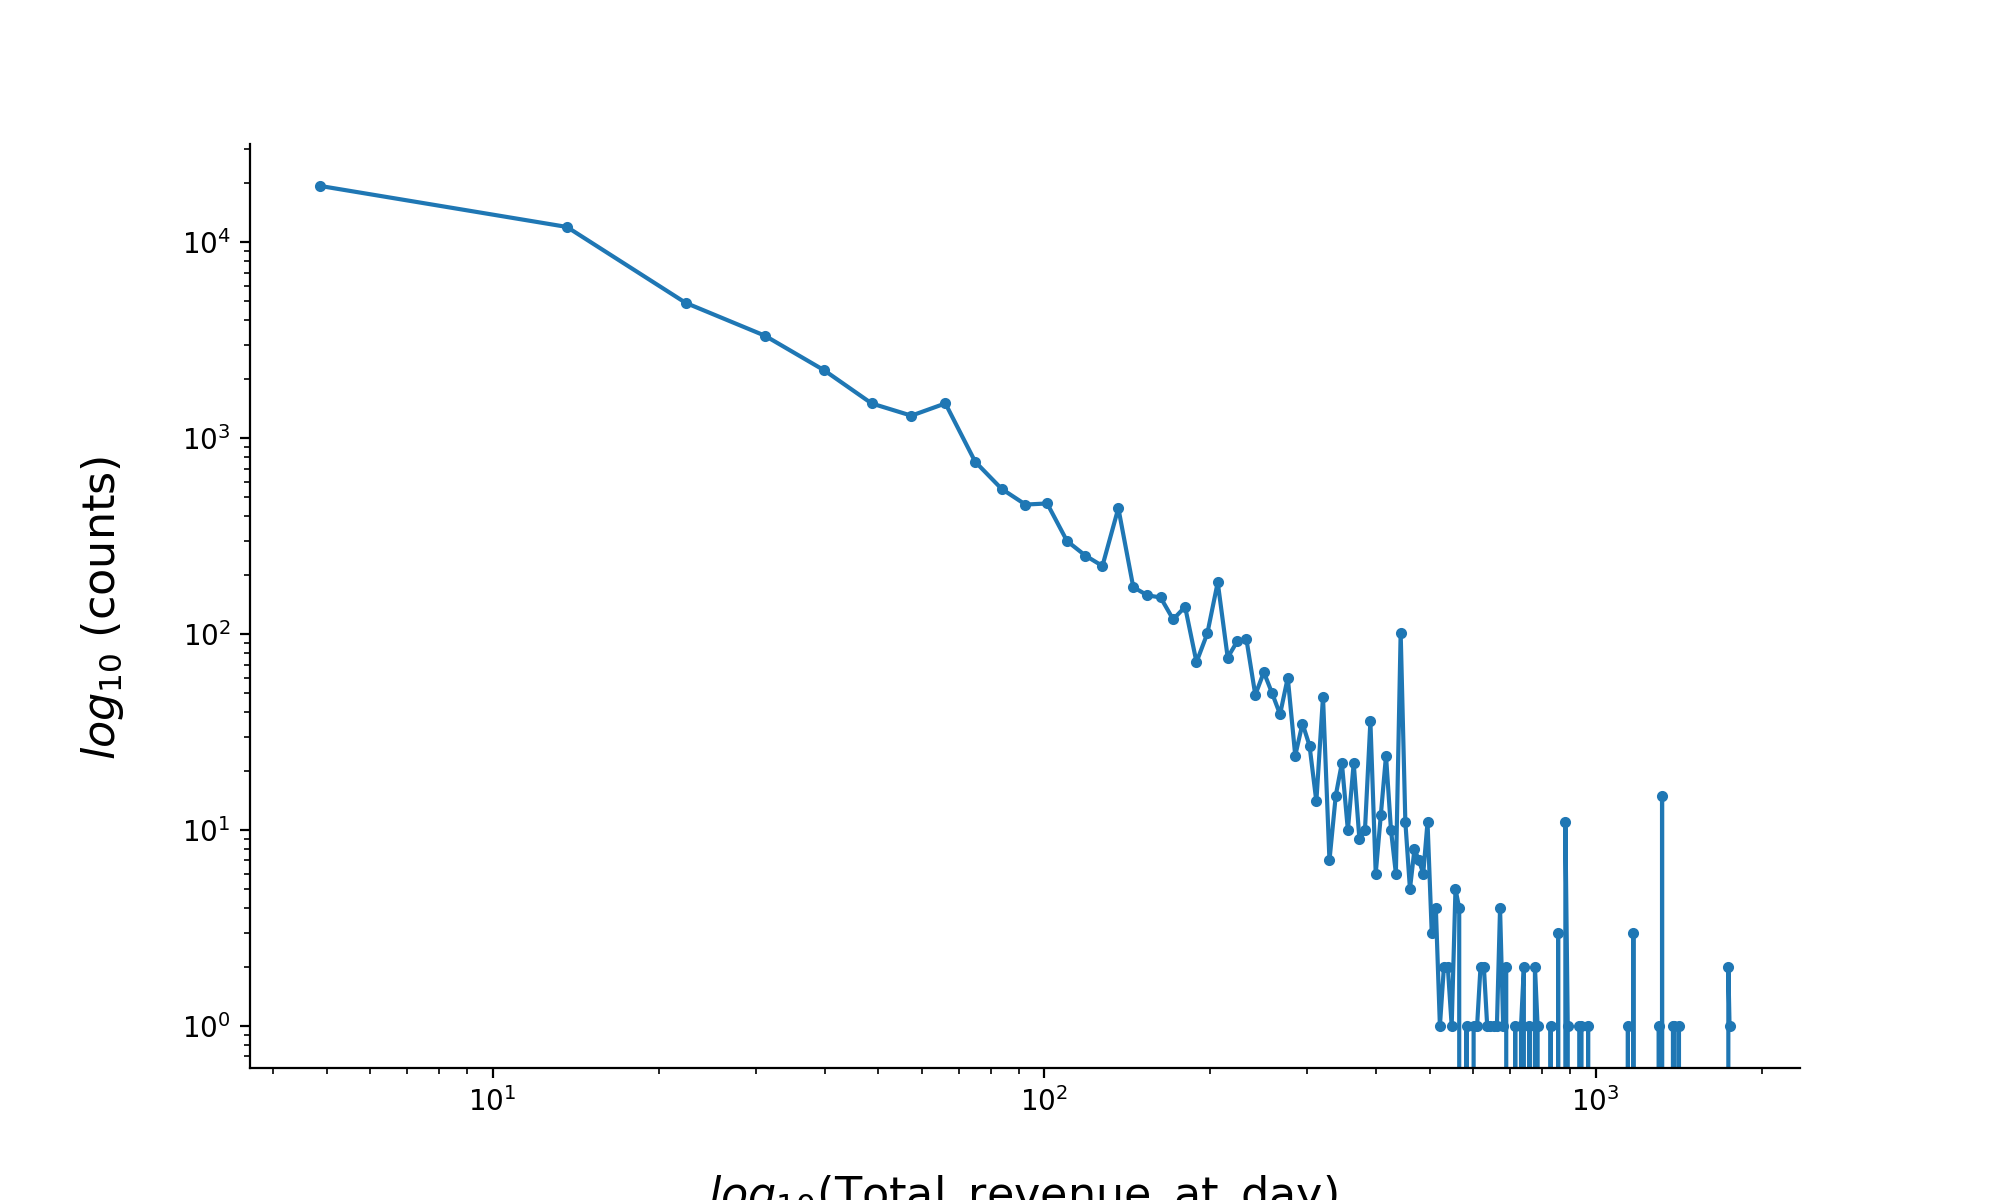



Looking at the revenue as a function of the user's index in the data frame:
(which is a proxy to the user's ID, which is a proxy to the user's seniority)


<IPython.core.display.Javascript object>


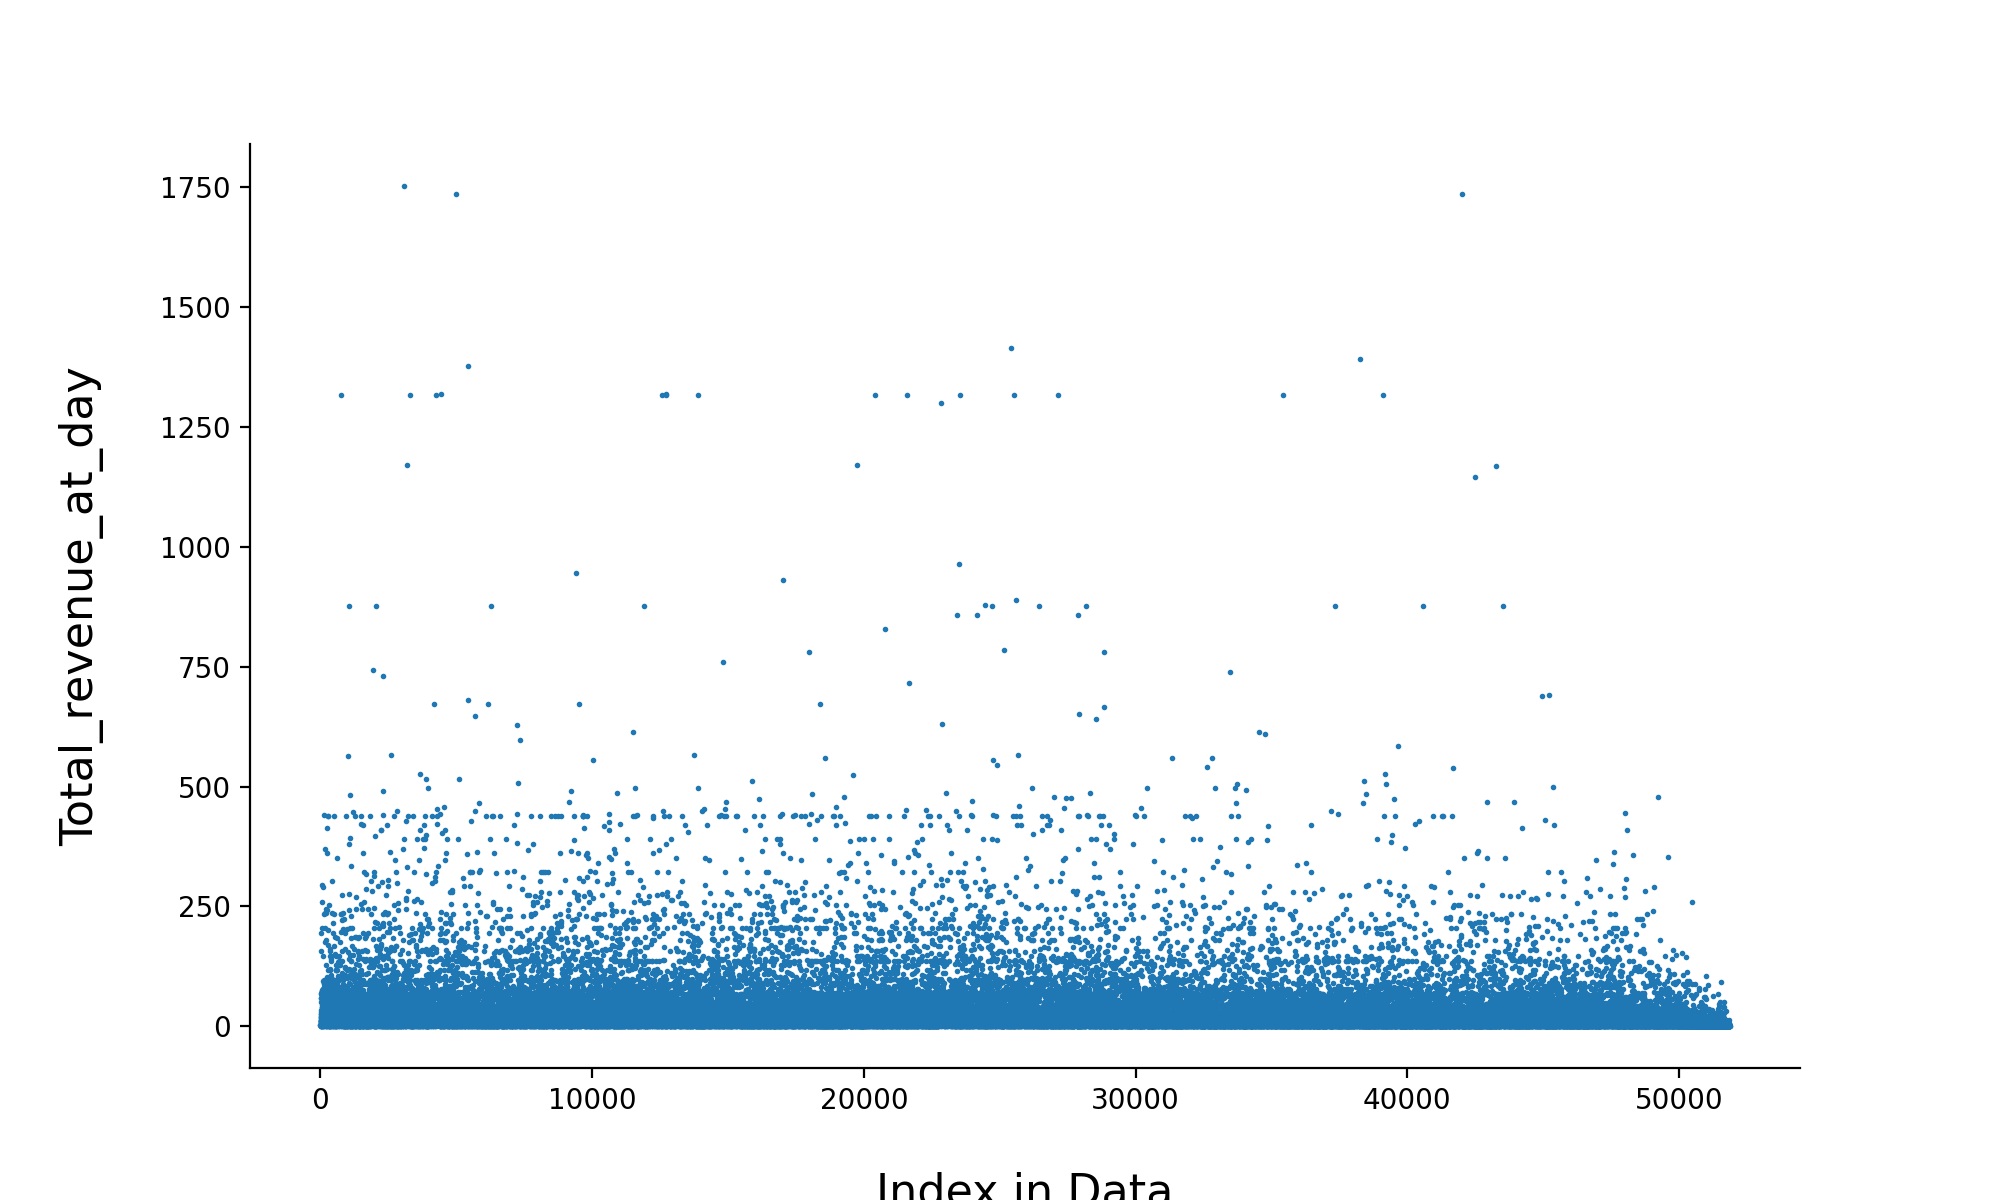


The shape of the target data frame is:
(51856, 3)

There are 0 **zeros** and 0 **nan** in the Total_revenue_at_day column

And the types of the data is:
dim_user_gid                     int64
Total_revenue_at_day           float64
num_purchase_events_of_user      int64
dtype: object


In [78]:
if parameters["data"]["target_data"]["init_data_analysis"]:
    if parameters["data"]["target_data"]["target_feature"] == "revenue": 
        data_target = run_revenue_init_data_analysis(data_target, 
                                                     target_column,
                                                     parameters["data"]["target_data"]["plot_figures"],
                                                     parameters["print_to_screen"])

[back to top](#back_to_top)  
[back to setting the parameters](#parameters) <a id='choose_features'></a>

## Choose features for clustering

In [155]:
if parameters["choose_features_for_clustering"]["randomly_choose"]:
    features_for_clustering = randomly_choose_features_for_clustering(numerical_features,
                                                                      parameters["choose_features_for_clustering"]["num_of_tupples"],
                                                                      parameters["choose_features_for_clustering"]["num_of_features"])    

else:
    features_for_clustering = parameters["choose_features_for_clustering"]["hand_picked_features_for_clustering"]
    checking_validity_of_hand_picked_features(features_for_clustering, numerical_features)

In [156]:
for features_tupple in features_for_clustering:
    print(features_tupple)

['total_rounds_mode_3', 'Lifetime_Revenue_Net', 'total_rounds_mode_1']
['llrecency', 'total_rounds_mode_3', 'Life_Time_Login_Days']
['llrecency', 'Last_30D_Transactions', 'Lifetime_Revenue_Net']
['Last_90D_Gross_Sink', 'total_rounds_mode_6', 'total_rounds_mode_2']
['total_rounds_mode_2', 'llrecency', 'total_rounds_mode_6']
['coins_balance_EOD', 'Last_30D_Gross_Sink', 'Last_90D_Login_days']
['total_rounds_mode_3', 'Life_Time_Login_Days', 'total_rounds_mode_5']
['total_rounds_mode_4', 'credits_balance_EOD', 'Last_30D_Gross_Sink']
['credits_balance_EOD', 'total_rounds_mode_1', 'Last_90D_Gross_Sink']
['credits_balance_EOD', 'total_rounds_mode_1', 'level']


[back to top](#back_to_top)  
[back to setting the parameters](#parameters) <a id='kmeans'></a>

## K-Means and Homogeneity calculations




---------------------------------------------------------------------

This is the 1 random tupple running.

No **nan** values in the data frame for clustering after the log transform. Please continue.
The chosen features are: ['dim_user_gid', 'total_rounds_mode_3', 'Lifetime_Revenue_Net', 'total_rounds_mode_1']
The data frame for the clustering has the following shape: (1200943, 4)
A quick view of it:

       dim_user_gid  total_rounds_mode_3  Lifetime_Revenue_Net  \
23899           261             -2.00000             -2.000000   
40151           288             -2.00000             -2.000000   
40152           312              0.69897             -2.000000   
68592           381             -2.00000              2.045168   
48277           391             -2.00000             -2.000000   
3584            427             -2.00000             -2.000000   
64529           458             -2.00000              2.832173   
52340           545             -2.00000              3.595365

<IPython.core.display.Javascript object>


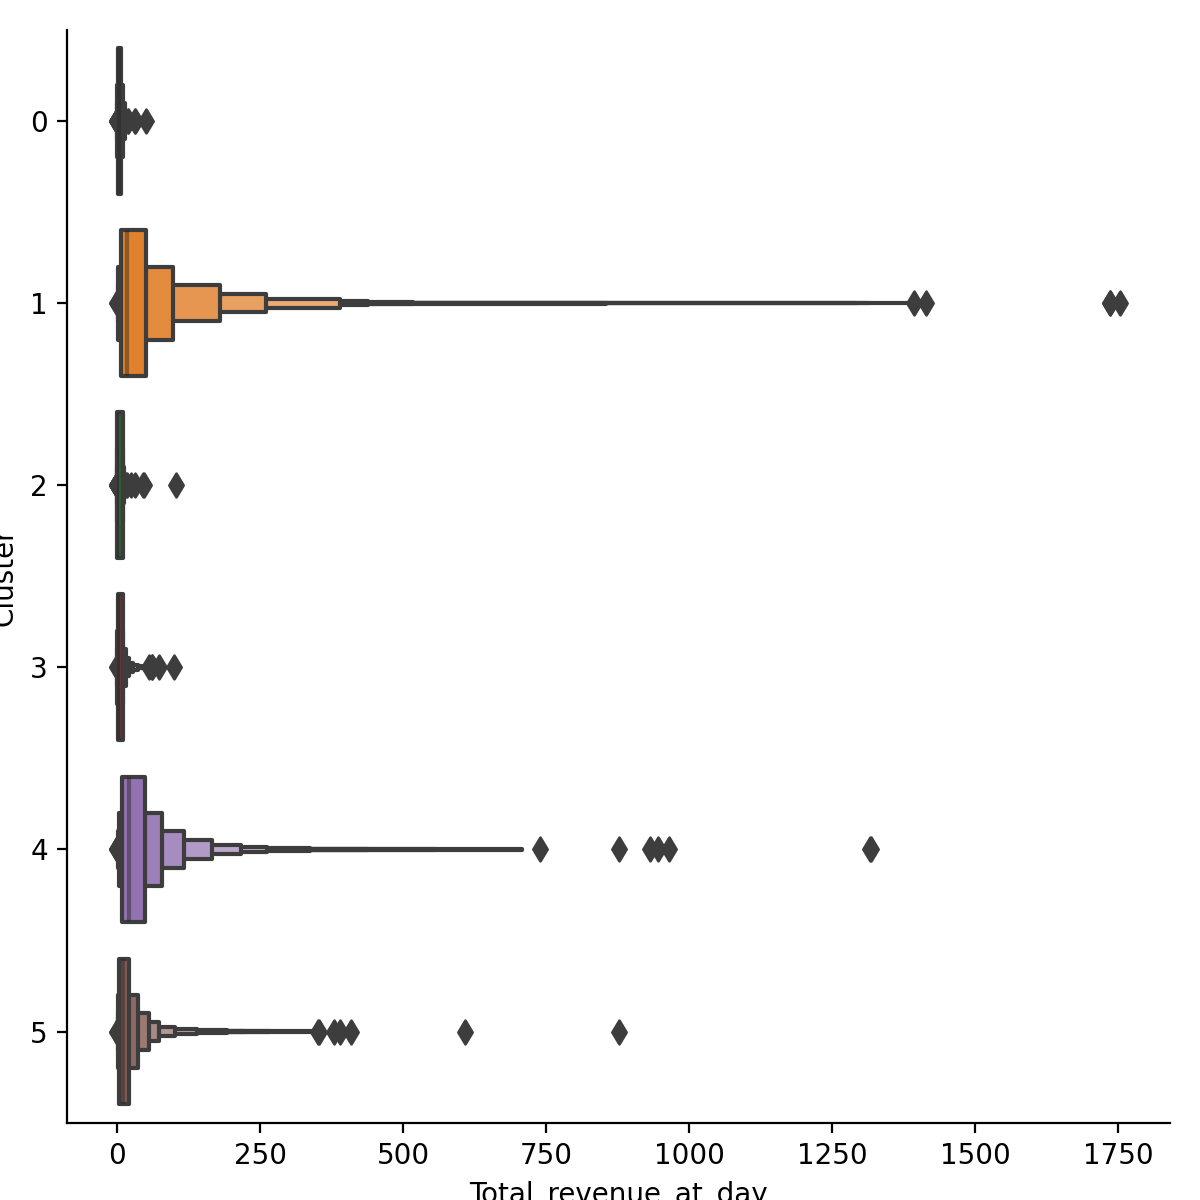

The target data is distributed among the different clusters as:
[163, 17463, 221, 2184, 12985, 12747]

0



---------------------------------------------------------------------

This is the 2 random tupple running.

No **nan** values in the data frame for clustering after the log transform. Please continue.
The chosen features are: ['dim_user_gid', 'llrecency', 'total_rounds_mode_3', 'Life_Time_Login_Days']
The data frame for the clustering has the following shape: (1200943, 4)
A quick view of it:

       dim_user_gid  llrecency  total_rounds_mode_3  Life_Time_Login_Days
23899           261    0.60206             -2.00000              1.857332
40151           288    0.00000             -2.00000              1.819544
40152           312    0.00000              0.69897              2.133539
68592           381    0.00000             -2.00000              2.487138
48277           391    0.00000             -2.00000              3.394452
3584            427    0.00000             -2.00000

<IPython.core.display.Javascript object>


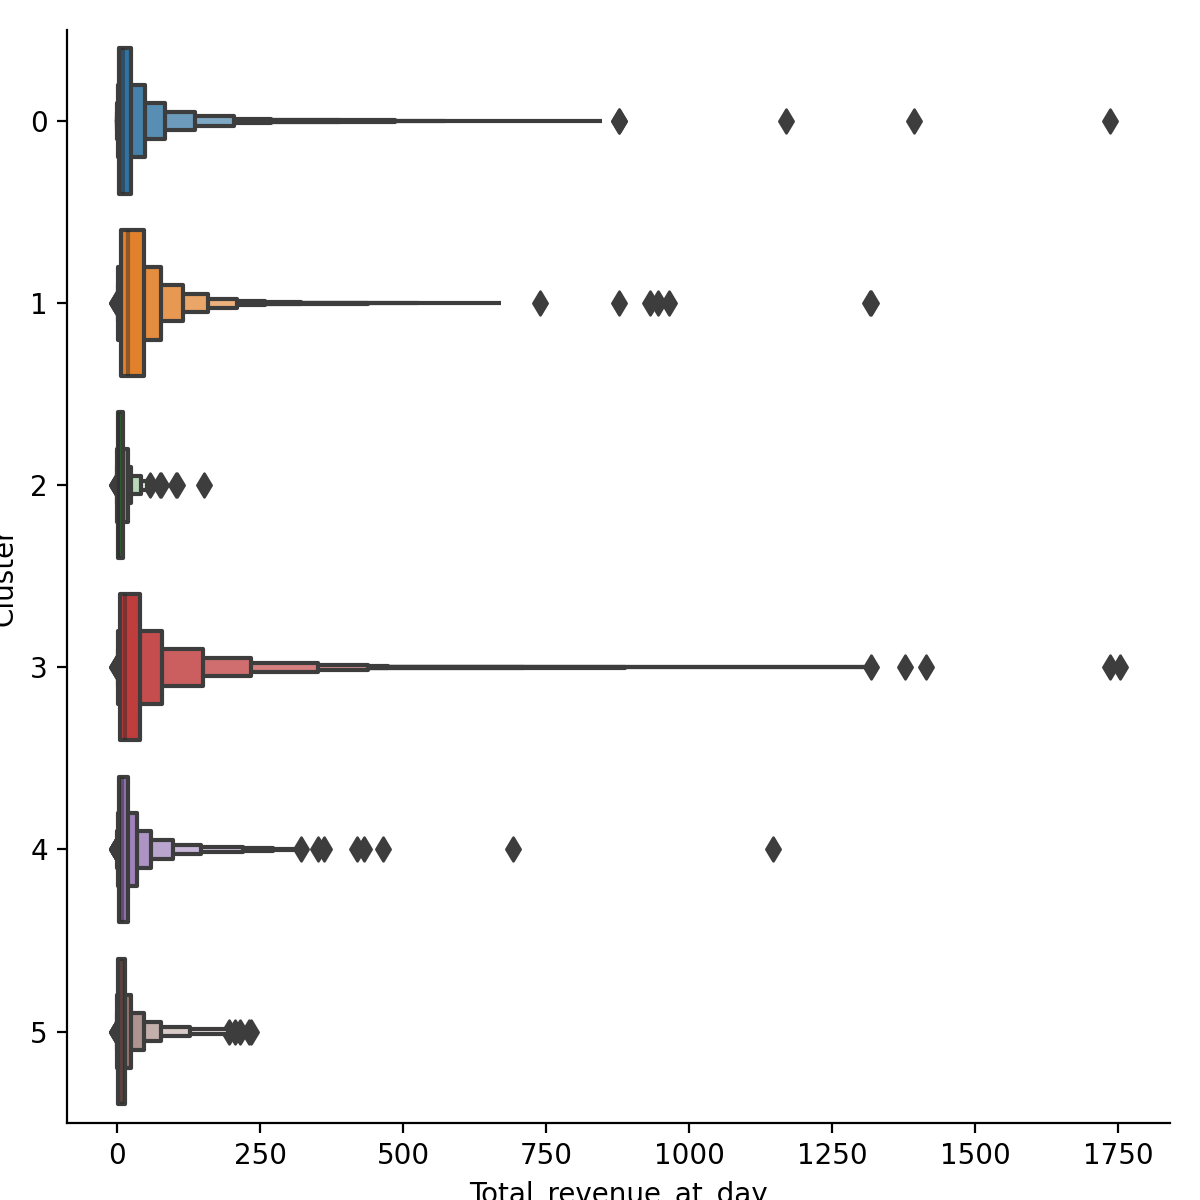

The target data is distributed among the different clusters as:
[8640, 13817, 374, 18499, 3825, 608]

0



---------------------------------------------------------------------

This is the 3 random tupple running.

No **nan** values in the data frame for clustering after the log transform. Please continue.
The chosen features are: ['dim_user_gid', 'llrecency', 'Last_30D_Transactions', 'Lifetime_Revenue_Net']
The data frame for the clustering has the following shape: (1200943, 4)
A quick view of it:

       dim_user_gid  llrecency  Last_30D_Transactions  Lifetime_Revenue_Net
23899           261    0.60206               -2.00000             -2.000000
40151           288    0.00000               -2.00000             -2.000000
40152           312    0.00000               -2.00000             -2.000000
68592           381    0.00000               -2.00000              2.045168
48277           391    0.00000               -2.00000             -2.000000
3584            427    0.00000        

<IPython.core.display.Javascript object>


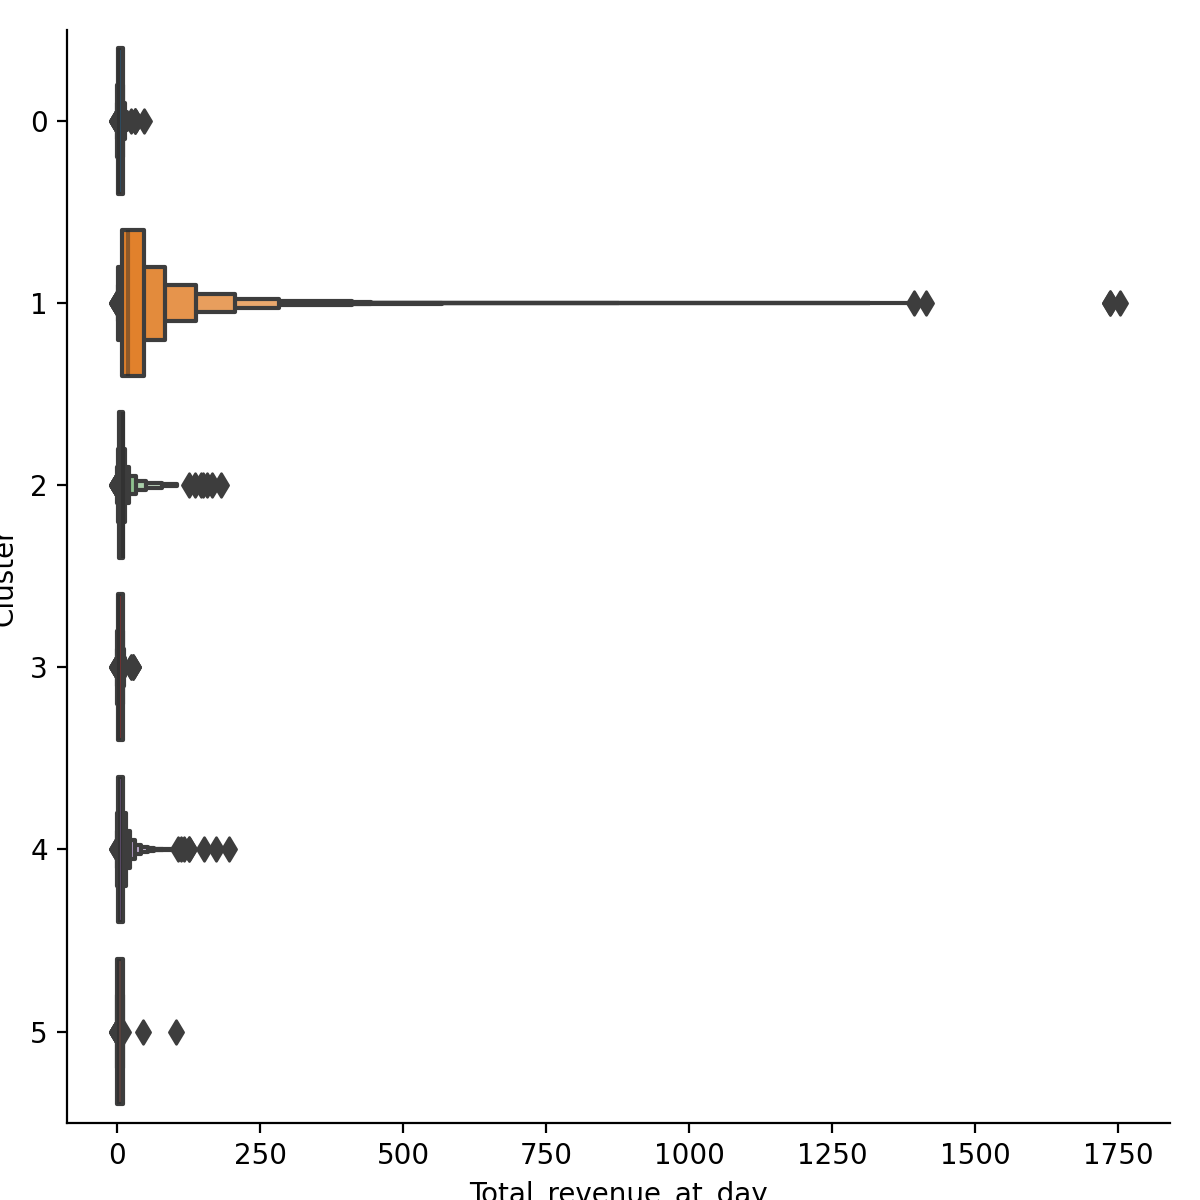

The target data is distributed among the different clusters as:
[308, 35277, 1729, 581, 7824, 44]

0



---------------------------------------------------------------------

This is the 4 random tupple running.

No **nan** values in the data frame for clustering after the log transform. Please continue.
The chosen features are: ['dim_user_gid', 'Last_90D_Gross_Sink', 'total_rounds_mode_6', 'total_rounds_mode_2']
The data frame for the clustering has the following shape: (1200943, 4)
A quick view of it:

       dim_user_gid  Last_90D_Gross_Sink  total_rounds_mode_6  \
23899           261             1.623249                 -2.0   
40151           288            -2.000000                 -2.0   
40152           312             4.727175                 -2.0   
68592           381             4.400279                 -2.0   
48277           391             4.541766                 -2.0   
3584            427             5.376827                 -2.0   
64529           458             4.8

<IPython.core.display.Javascript object>


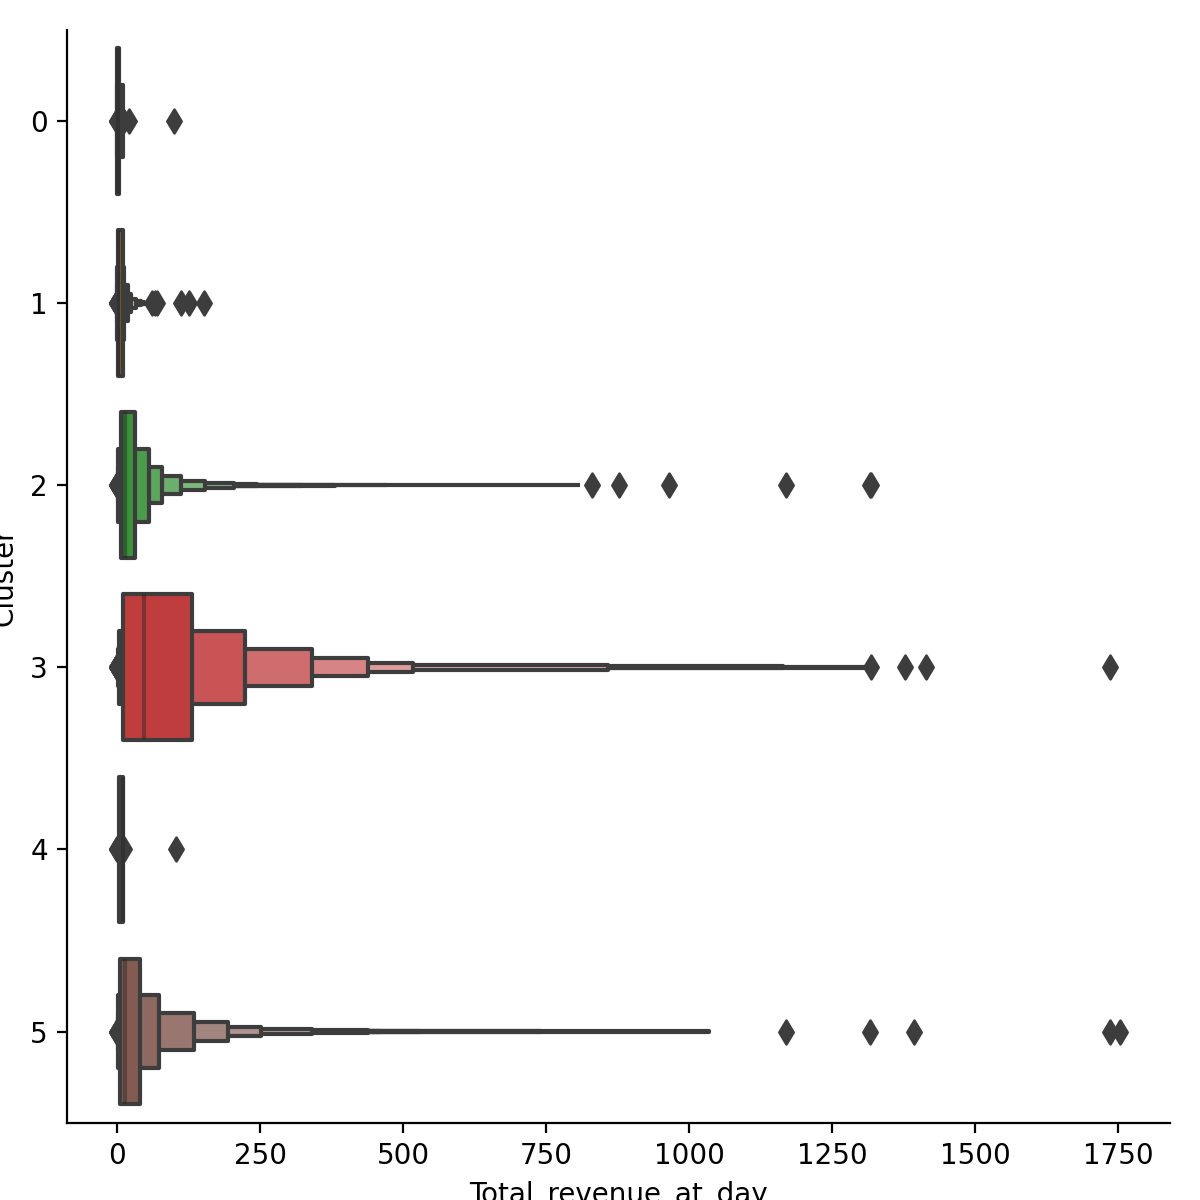

The target data is distributed among the different clusters as:
[40, 2909, 20877, 3646, 22, 18269]

0



---------------------------------------------------------------------

This is the 5 random tupple running.

No **nan** values in the data frame for clustering after the log transform. Please continue.
The chosen features are: ['dim_user_gid', 'total_rounds_mode_2', 'llrecency', 'total_rounds_mode_6']
The data frame for the clustering has the following shape: (1200943, 4)
A quick view of it:

       dim_user_gid  total_rounds_mode_2  llrecency  total_rounds_mode_6
23899           261             -2.00000    0.60206                 -2.0
40151           288             -2.00000    0.00000                 -2.0
40152           312             -2.00000    0.00000                 -2.0
68592           381             -2.00000    0.00000                 -2.0
48277           391             -2.00000    0.00000                 -2.0
3584            427             -2.00000    0.00000          

<IPython.core.display.Javascript object>


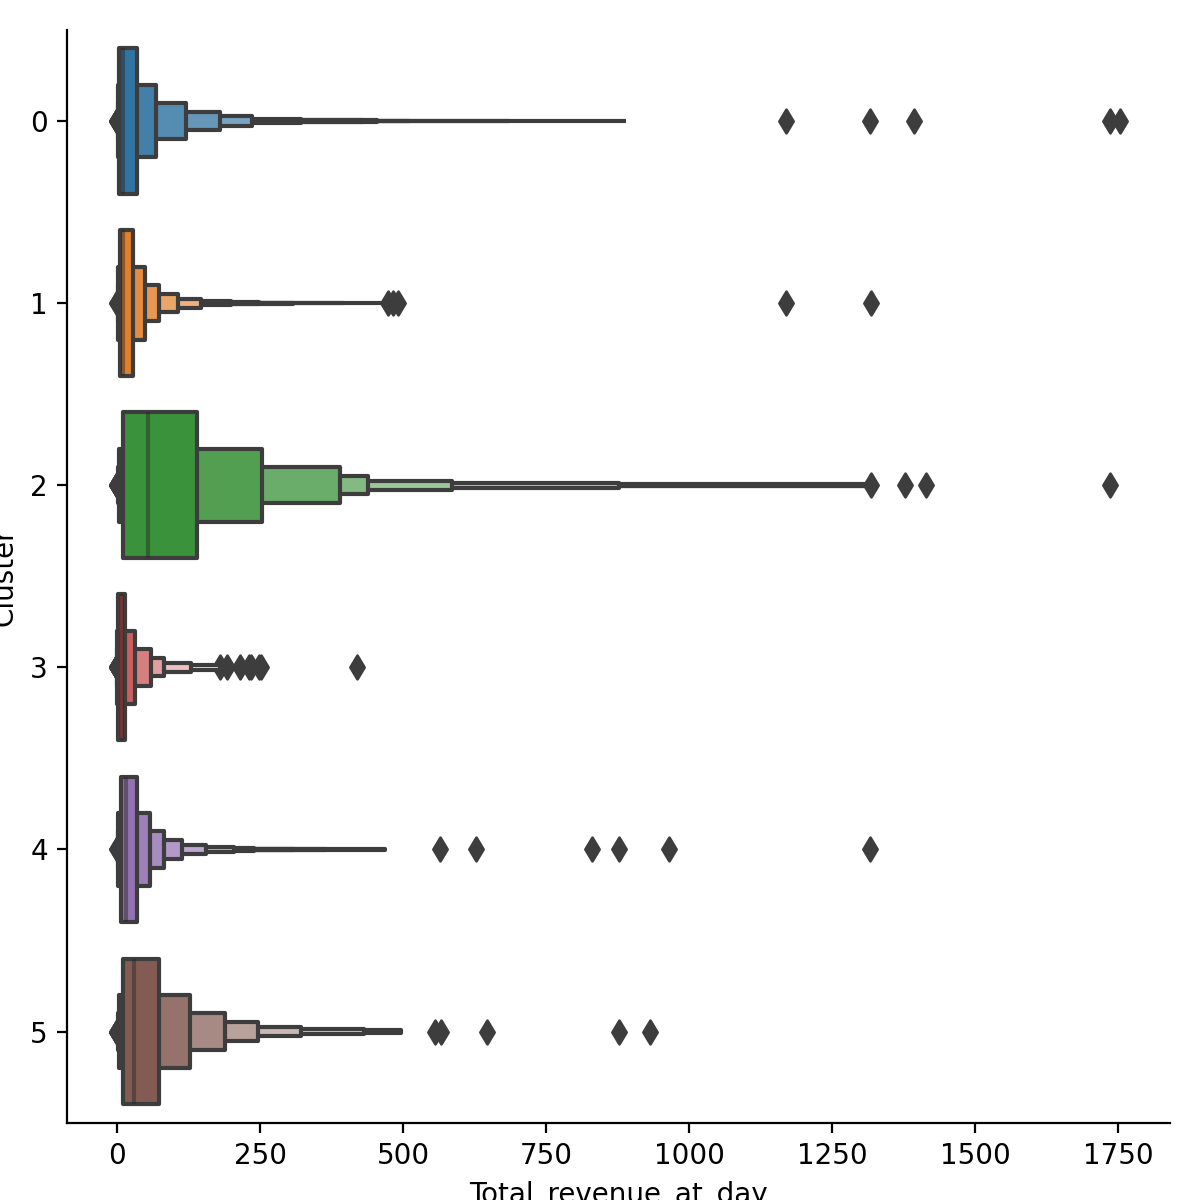

The target data is distributed among the different clusters as:
[20303, 8715, 2747, 936, 11798, 1264]

0



---------------------------------------------------------------------

This is the 6 random tupple running.

No **nan** values in the data frame for clustering after the log transform. Please continue.
The chosen features are: ['dim_user_gid', 'coins_balance_EOD', 'Last_30D_Gross_Sink', 'Last_90D_Login_days']
The data frame for the clustering has the following shape: (1200943, 4)
A quick view of it:

       dim_user_gid  coins_balance_EOD  Last_30D_Gross_Sink  \
23899           261           5.995521             1.623249   
40151           288           5.113566            -2.000000   
40152           312           5.686191             4.229221   
68592           381           6.106410             2.653213   
48277           391           3.615740             4.063709   
3584            427           3.995811             4.325926   
64529           458           4.092615         

<IPython.core.display.Javascript object>


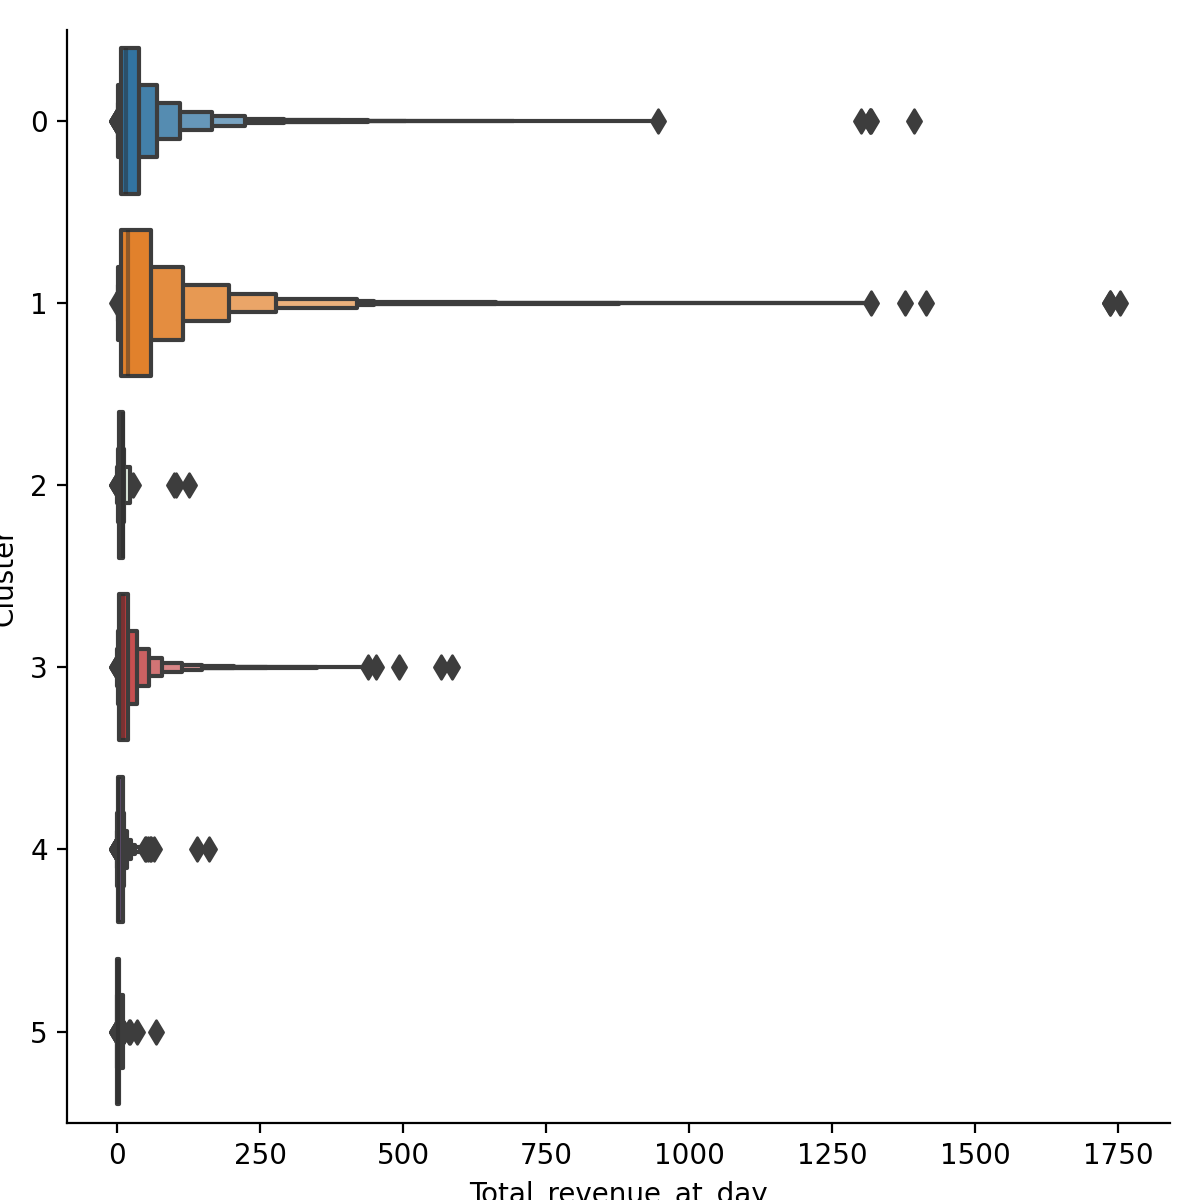

The target data is distributed among the different clusters as:
[23534, 11578, 73, 8636, 1879, 63]

0



---------------------------------------------------------------------

This is the 7 random tupple running.

No **nan** values in the data frame for clustering after the log transform. Please continue.
The chosen features are: ['dim_user_gid', 'total_rounds_mode_3', 'Life_Time_Login_Days', 'total_rounds_mode_5']
The data frame for the clustering has the following shape: (1200943, 4)
A quick view of it:

       dim_user_gid  total_rounds_mode_3  Life_Time_Login_Days  \
23899           261             -2.00000              1.857332   
40151           288             -2.00000              1.819544   
40152           312              0.69897              2.133539   
68592           381             -2.00000              2.487138   
48277           391             -2.00000              3.394452   
3584            427             -2.00000              3.065953   
64529           458       

<IPython.core.display.Javascript object>


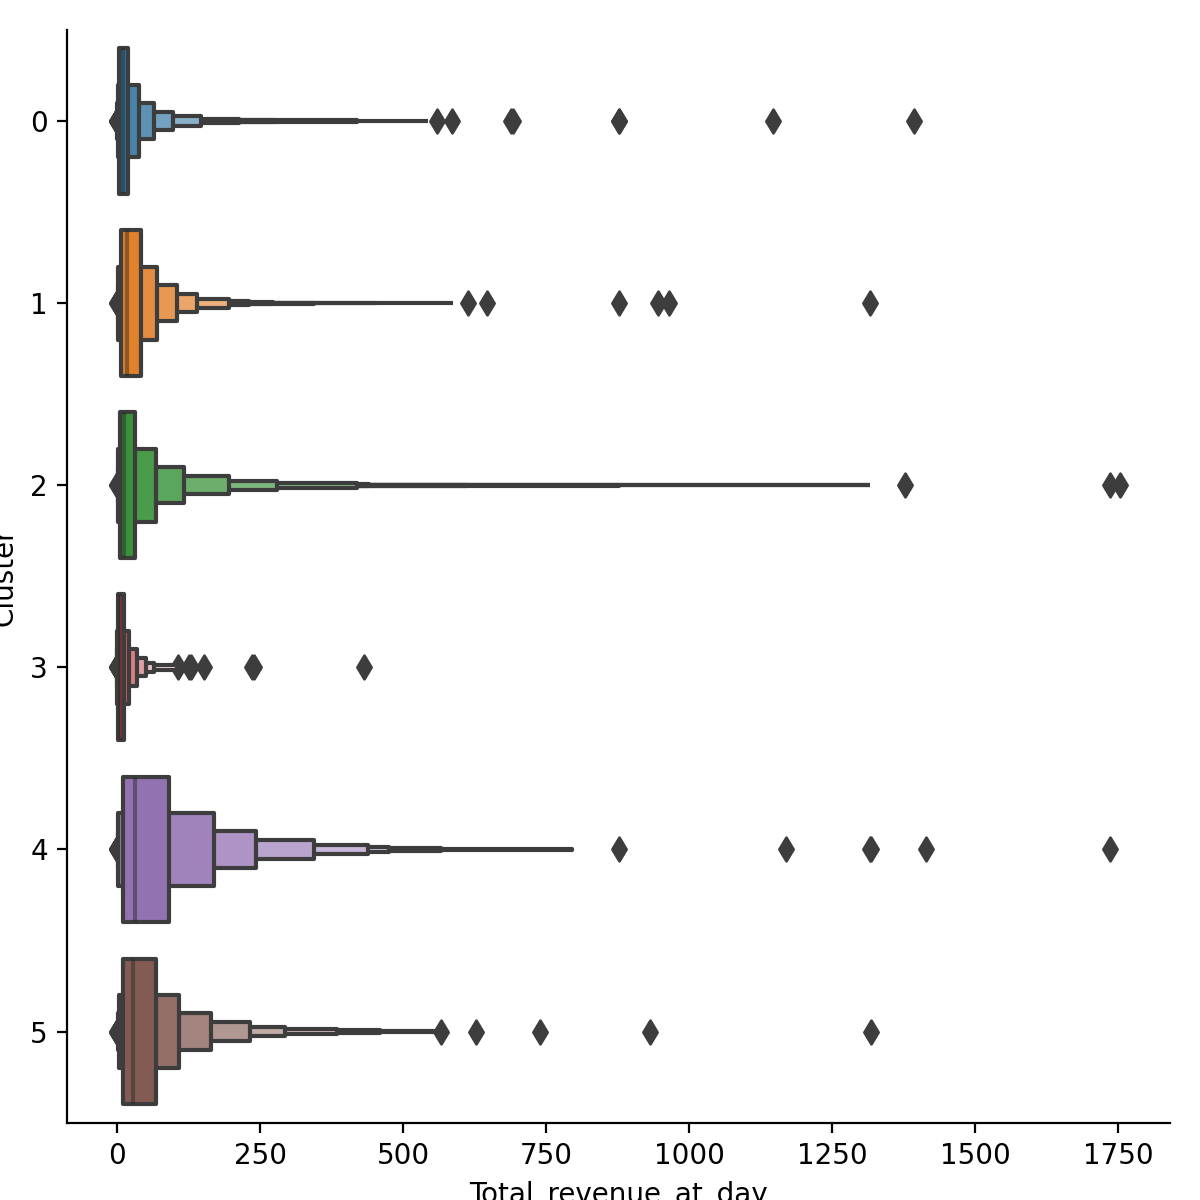

The target data is distributed among the different clusters as:
[7967, 11358, 20108, 855, 3014, 2461]

0



---------------------------------------------------------------------

This is the 8 random tupple running.

No **nan** values in the data frame for clustering after the log transform. Please continue.
The chosen features are: ['dim_user_gid', 'total_rounds_mode_4', 'credits_balance_EOD', 'Last_30D_Gross_Sink']
The data frame for the clustering has the following shape: (1200943, 4)
A quick view of it:

       dim_user_gid  total_rounds_mode_4  credits_balance_EOD  \
23899           261                 -2.0             4.380066   
40151           288                 -2.0             2.771587   
40152           312                 -2.0             2.445604   
68592           381                 -2.0             3.755722   
48277           391                 -2.0             0.602060   
3584            427                 -2.0             2.629410   
64529           458            

<IPython.core.display.Javascript object>


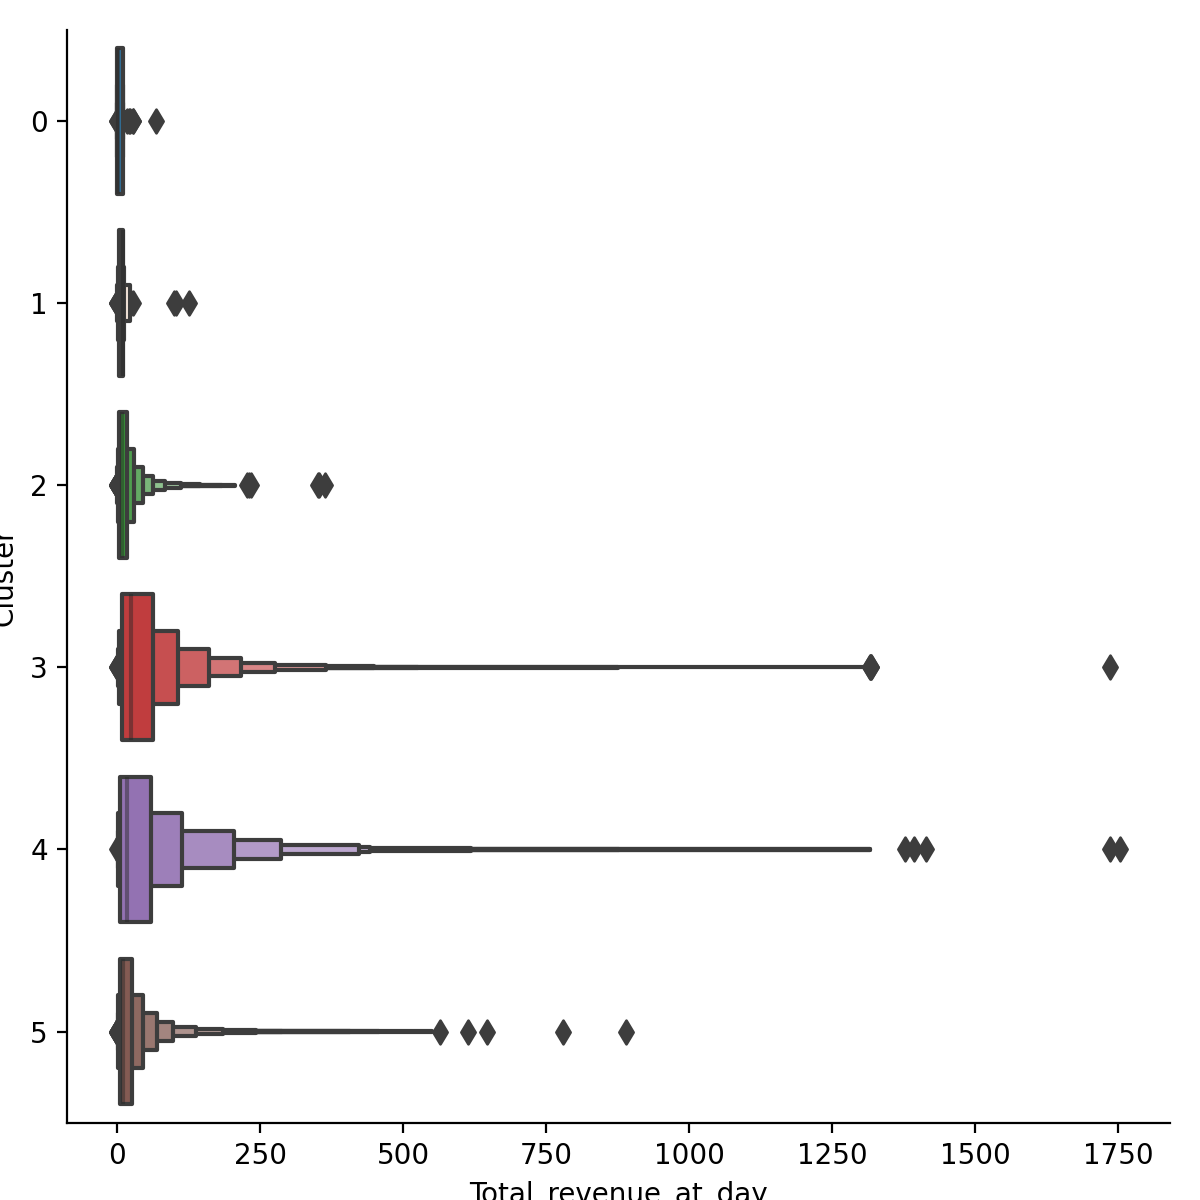

The target data is distributed among the different clusters as:
[172, 73, 6023, 8958, 11964, 18573]

0



---------------------------------------------------------------------

This is the 9 random tupple running.

No **nan** values in the data frame for clustering after the log transform. Please continue.
The chosen features are: ['dim_user_gid', 'credits_balance_EOD', 'total_rounds_mode_1', 'Last_90D_Gross_Sink']
The data frame for the clustering has the following shape: (1200943, 4)
A quick view of it:

       dim_user_gid  credits_balance_EOD  total_rounds_mode_1  \
23899           261             4.380066             -2.00000   
40151           288             2.771587             -2.00000   
40152           312             2.445604             -2.00000   
68592           381             3.755722             -2.00000   
48277           391             0.602060              0.69897   
3584            427             2.629410             -2.00000   
64529           458             2

<IPython.core.display.Javascript object>


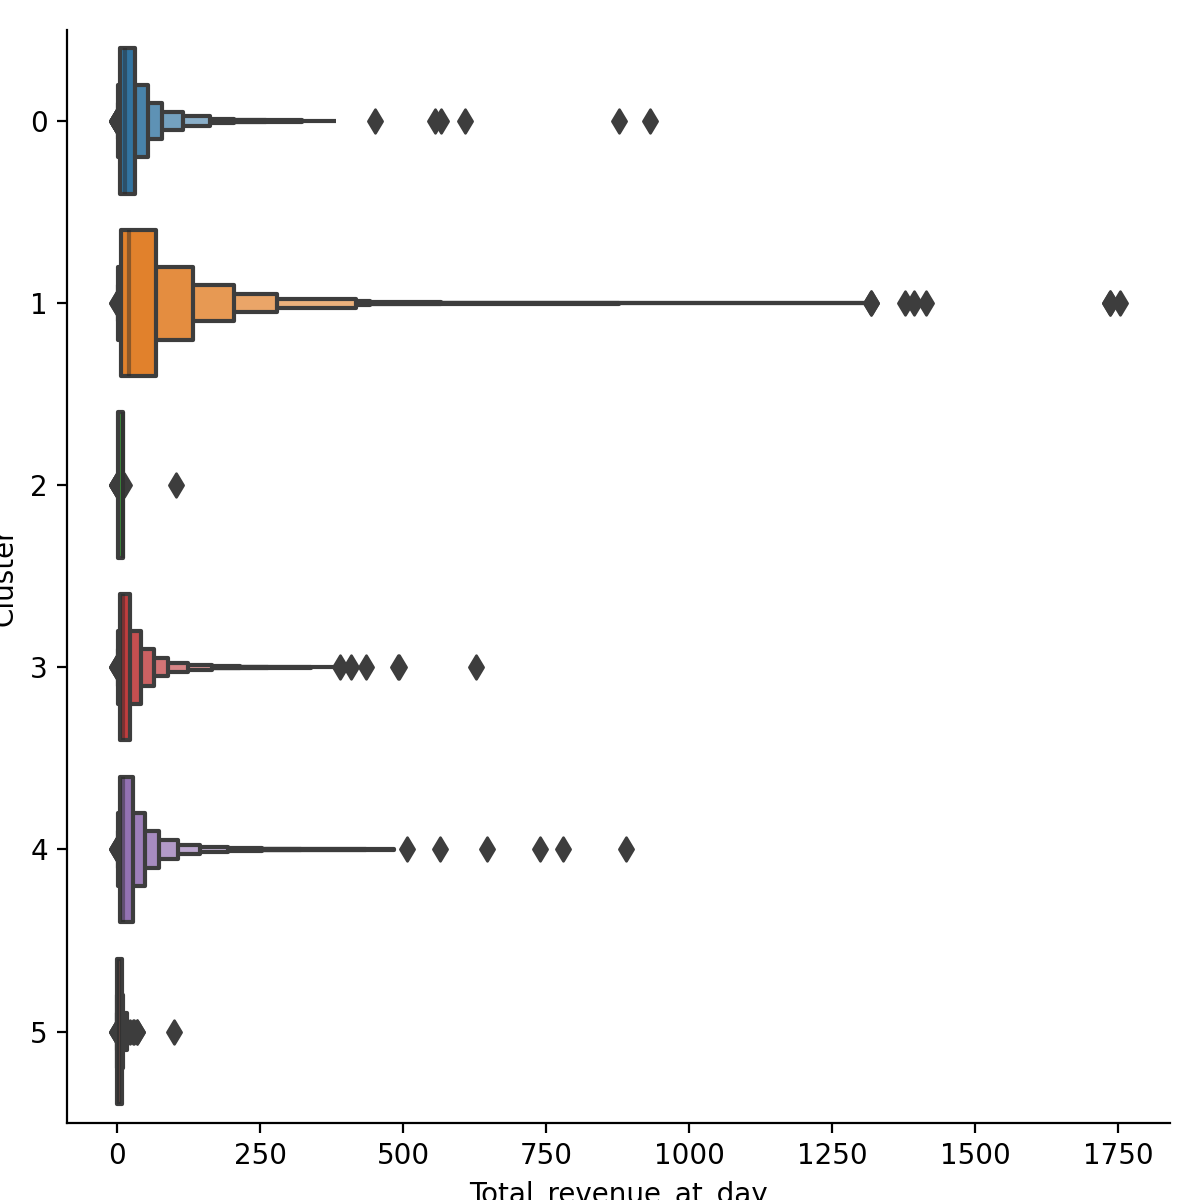

The target data is distributed among the different clusters as:
[6115, 15811, 23, 11446, 12245, 123]

0



---------------------------------------------------------------------

This is the 10 random tupple running.

No **nan** values in the data frame for clustering after the log transform. Please continue.
The chosen features are: ['dim_user_gid', 'credits_balance_EOD', 'total_rounds_mode_1', 'level']
The data frame for the clustering has the following shape: (1200943, 4)
A quick view of it:

       dim_user_gid  credits_balance_EOD  total_rounds_mode_1     level
23899           261             4.380066             -2.00000  1.869232
40151           288             2.771587             -2.00000  1.886491
40152           312             2.445604             -2.00000  1.986772
68592           381             3.755722             -2.00000  2.110590
48277           391             0.602060              0.69897  2.385606
3584            427             2.629410             -2.00000  2.318

<IPython.core.display.Javascript object>


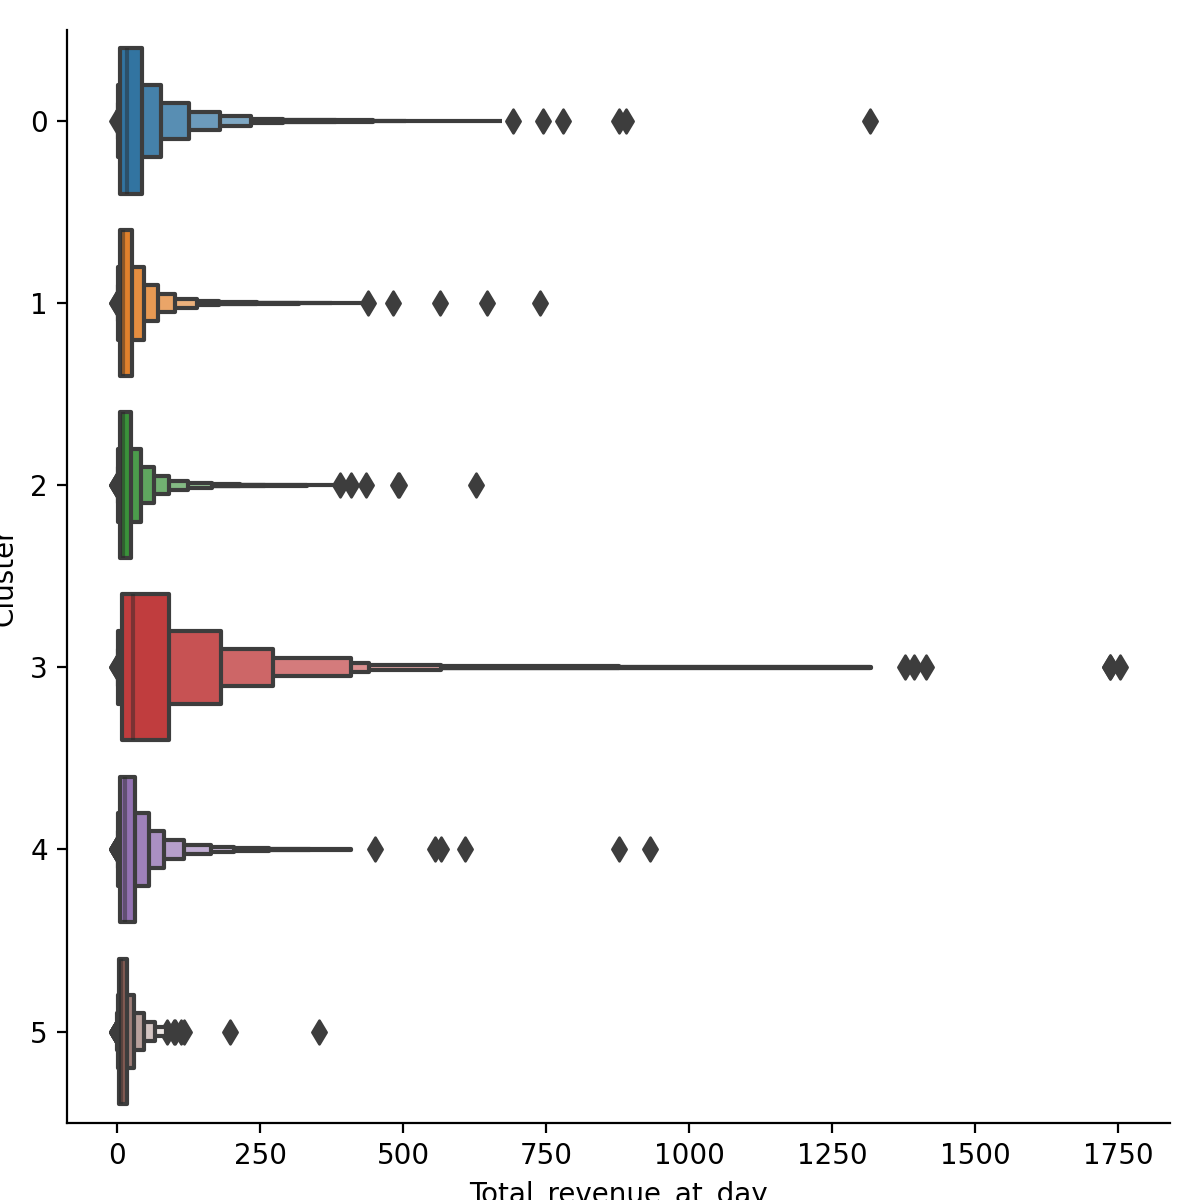

The target data is distributed among the different clusters as:
[12231, 8836, 11478, 7044, 5737, 437]

0

The time it took to complete 10 runs, each with 4 features and 6 clusters,
and True using bootstrap with 1000 replicas is:
755.39 seconds


In [158]:
start_time = time.time()

for ind, features_tupple in enumerate(features_for_clustering):
    results_summary["results"].update({"run_{}".format(ind): {}})
    results_summary["results"]["run_{}".format(ind)].update({"features_for_clustering": features_tupple})
    
    if parameters["print_to_screen"]:
        print("\n\n")
        print("---------------------------------------------------------------------\n")
        print("This is the {} random tupple running.\n".format(ind + 1))
    
    # Kmeans part:
    features_tupple.insert(0, 'dim_user_gid')
    X = create_df_for_kmeans(data_for_clustering, 
                             features_tupple,
                             parameters["kmeans"],
                             parameters["print_to_screen"])

    if parameters["kmeans"]["optimal_k"]["to_find_optimal_k"]:
        optimal_k = find_optimal_k(X, 
                                   parameters["kmeans"],
                                   parameters["print_to_screen"])
        results_summary["results"]["run_{}".format(ind)].update({"optimal_k": optimal_k})
        
    if parameters["kmeans"]["choice_of_num_of_clusters"] == "sse":
        num_of_clusters = optimal_k["sse"]
    elif parameters["kmeans"]["choice_of_num_of_clusters"] == "silhouette":
        num_of_clusters = optimal_k["silhouette"]
    elif parameters["kmeans"]["choice_of_num_of_clusters"] == "manual":
        num_of_clusters = parameters["kmeans"]["hand_picked_num_of_clusters"]
    
    if parameters["print_to_screen"]:
        print("\nThe number of clusters is: {}".format(num_of_clusters))
        
    X = run_kmeans(X, 
                   num_of_clusters, 
                   parameters["kmeans"],
                   parameters["print_to_screen"])
    
    # Homogeneity part:
    X_merged_with_target = find_users_in_both_features_data_and_target(X, 
                                                                       data_target,
                                                                       parameters["print_to_screen"])
    
    if parameters["homogeneity"]["show_target_distribution_by_cluster"]:
        plot_dist_of_target_at_clusters(X_merged_with_target,
                                        target_column)
        
    if parameters["homogeneity"]["calculate_homogeneity"]:
        homogeneity_results = calc_homogeneity(X_merged_with_target,
                                               num_of_clusters,
                                               target_column,
                                               parameters["homogeneity"],
                                               parameters["print_to_screen"])
        results_summary["results"]["run_{}".format(ind)].update({"homogeneity_results": homogeneity_results})
        
print()
print("The time it took to complete {} runs, each with {} features and {} clusters,".format(len(features_for_clustering), len(features_for_clustering[0]), num_of_clusters))
print("and {} using bootstrap with {} replicas is:".format(parameters["homogeneity"]["bootstrap"], parameters["homogeneity"]["num_of_bootstrap_runs"]))
print("{:.2f} seconds".format(time.time() - start_time))

In [162]:
for ind, features_tupple in enumerate(features_for_clustering):
    print("\n\n")
    print("---------------------------------------------------------------------\n")
    print("Summary of results for run {}:\n".format(ind))
    print("The features:\n{}".format(features_tupple[1:]))
    print()
    print("Weighted average homogeneity by **percentile**: {}".format(results_summary["results"]["run_{}".format(ind)]['homogeneity_results']["homogeneity_by_percentile"]["weighted_homogeneity_avg"]))
    print("Percentile of the bootstrap distribution (smaller than 0.95 means it is not significant): {}".format(results_summary["results"]["run_{}".format(ind)]['homogeneity_results']["bootstrap_results"]["percentile"]["avg_weighted_homogeneity"]["data point as percentile of bootstrap"]))
    
    print()
    print("Weighted average homogeneity by **min-max**: {}".format(results_summary["results"]["run_{}".format(ind)]['homogeneity_results']["homogeneity_by_min_max"]["weighted_homogeneity_avg"]))
    print("Percentile of the bootstrap distribution (smaller than 0.95 means it is not significant): {}".format(results_summary["results"]["run_{}".format(ind)]['homogeneity_results']["bootstrap_results"]["min_max"]["avg_weighted_homogeneity"]["data point as percentile of bootstrap"]))
    
    print()
    print("Weighted average homogeneity by **distance**: {}".format(results_summary["results"]["run_{}".format(ind)]['homogeneity_results']["homogeneity_by_distance"]["weighted_homogeneity_avg"]))
    print("Percentile of the bootstrap distribution (smaller than 0.95 means it is not significant): {}".format(results_summary["results"]["run_{}".format(ind)]['homogeneity_results']["bootstrap_results"]["distance"]["avg_weighted_homogeneity"]["data point as percentile of bootstrap"]))
    




---------------------------------------------------------------------

Summary of results for run 0:

The features:
['total_rounds_mode_3', 'Lifetime_Revenue_Net', 'total_rounds_mode_1']

Weighted average homogeneity by **percentile**: -0.07764275249393553
Percentile of the bootstrap distribution (smaller than 0.95 means it is not significant): 0.0

Weighted average homogeneity by **min-max**: 0.2626053680499394
Percentile of the bootstrap distribution (smaller than 0.95 means it is not significant): 1.0

Weighted average homogeneity by **distance**: 0.042690521805488324
Percentile of the bootstrap distribution (smaller than 0.95 means it is not significant): 1.0



---------------------------------------------------------------------

Summary of results for run 1:

The features:
['llrecency', 'total_rounds_mode_3', 'Life_Time_Login_Days']

Weighted average homogeneity by **percentile**: -0.009449805311684446
Percentile of the bootstrap distribution (smaller than 0.95 means it is no

In [163]:
pp.pprint(results_summary["results"]["run_9"]['homogeneity_results']["bootstrap_results"])

{   'distance': {   'avg_homogeneity': {   '2.5% percentile': -0.217699346331519,
                                           '97.5% percentile': 0.09415430718623982,
                                           'average': -0.0040311423870962974,
                                           'data point as percentile of bootstrap': 0.969},
                    'avg_weighted_homogeneity': {   '2.5% percentile': 1.8019138860346315e-05,
                                                    '97.5% percentile': 0.0002959585793279817,
                                                    'average': 0.00011074704695601074,
                                                    'data point as percentile of bootstrap': 1.0}},
    'min_max': {   'avg_homogeneity': {   '2.5% percentile': 0.11490028900357026,
                                          '97.5% percentile': 0.27893596438976,
                                          'average': 0.2000296147012794,
                                          'data poin

In [140]:
print(results_summary["results"]["run_0"]['homogeneity_results']["homogeneity_by_percentile"]["weighted_homogeneity_avg"])
print(results_summary["results"]["run_1"]['homogeneity_results']["homogeneity_by_percentile"]["weighted_homogeneity_avg"])
print(results_summary["results"]["run_2"]['homogeneity_results']["homogeneity_by_percentile"]["weighted_homogeneity_avg"])

-0.017208114671964744
-0.0004099757311150977
0.012752097059403698


In [141]:
print(results_summary["results"]["run_0"]['homogeneity_results']["homogeneity_by_min_max"]["homogeneity_avg"])
print(results_summary["results"]["run_1"]['homogeneity_results']["homogeneity_by_min_max"]["homogeneity_avg"])
print(results_summary["results"]["run_2"]['homogeneity_results']["homogeneity_by_min_max"]["homogeneity_avg"])

0.7567295768806058
0.8115623273113322
0.5661666027450815


In [142]:
print(results_summary["results"]["run_0"]['homogeneity_results']["homogeneity_by_distance"]["homogeneity_avg"])
print(results_summary["results"]["run_1"]['homogeneity_results']["homogeneity_by_distance"]["homogeneity_avg"])
print(results_summary["results"]["run_2"]['homogeneity_results']["homogeneity_by_distance"]["homogeneity_avg"])

0.6662405967124071
0.7849929404228962
-0.20014694095602317


In [143]:
print(results_summary["results"]["run_0"]['homogeneity_results']["homogeneity_by_distance"]["weighted_homogeneity_avg"])
print(results_summary["results"]["run_1"]['homogeneity_results']["homogeneity_by_distance"]["weighted_homogeneity_avg"])
print(results_summary["results"]["run_2"]['homogeneity_results']["homogeneity_by_distance"]["weighted_homogeneity_avg"])

0.059052917820895265
0.054392846558375556
0.05107719944068967


[back to top](#back_to_top)  
[back to setting the parameters](#parameters) <a id='saving_results'></a>

## Saving the results

In [ ]:
results_summary.update({"parameters": parameters})